Computational Photography, ELEC 549, Fall 2023, Rice University,

Instructor: Ashok Veeraraghavan,

Authors: Sean Farrell, Aniket Dashpute

# HW 1 - Static Multi-image Denoising

This homework is an exercise on multi-image denoising using non-learning based methods. First we use noisy images simulated from a noise-free image rendered in Blender. Then from the image stack simple pixel-wise and block-wise averaging and median filtering are applied to denoise the image.

Then refer to a paper (linked later), and implement one of the methods mentioned there in the orthogonal transform domain.

NOTE: WHERE IT SAYS "=== SECOND TRANSFORM STARTS HERE===" OR "THIRD TRANSFORM ENDS HERE" UNCOMMENT THAT TO GET 3 WAVELET TRANSFORMS, AND ADD "_3" to sigma_estimate at the end of the method.

In [82]:
# mount drive
from google.colab import drive, files
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [83]:
# move to ashok hw directory
%cd drive/MyDrive/Ashok_Hw1_Part1_Data

[Errno 2] No such file or directory: 'drive/MyDrive/Ashok_Hw1_Part1_Data'
/content/drive/.shortcut-targets-by-id/1Gqvhjg_e3WtD9BIsmZkIlxq7n6R2rKY0/Ashok_Hw1_Part1_Data


**Note:**
1. Make sure all the required data is unzipped and is loaded into the workspace.
2. Remember to first make your own copy of this notebook, if you make changes here directly, they might not be saved

In [84]:
# Import necessary packages
import numpy as np
import os
import cv2
import sys
from scipy.fftpack import dct, idct
from scipy import ndimage
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt
import pywt
import copy

Helper functions

In [85]:
# To start with, we define some functions for you
def normalize_2D(x):
  '''
  This function normalizes a 2D image between 0 and 1
  '''
  return (x-np.min(x))/(np.max(x)-np.min(x))

def psnr(ref,x):
  '''
  This function computes the peak-signal-to-noise-ratio
  between two images in decibles (dB).
  '''
  if ref.size != x.size:
    print('ERROR: two images should be the same size to compute psnr.\n')
    sys.exit()
  ref = ref.astype(np.float64)
  x = x.astype(np.float64)
  RMSE = np.sqrt(np.sum((ref-x)**2)/ref.size)

  return 20*np.log10(np.max(ref)/RMSE)

def dct2D(x):
  '''
  Implements 2D discrete cosine transform (DCT)
  '''
  return dct(dct(x,axis=0,norm='ortho'),axis=1,norm='ortho')

def idct2D(x):
  '''
  Implements 2D inverse discrete cosine transform (IDCT)
  '''
  return idct(idct(x,axis=0, norm='ortho'),axis=1,norm='ortho')

def dct3D(x):
  '''
  Implements 3D discrete cosine transform (DCT)
  '''
  z = dct(dct(dct(x,axis=0,norm='ortho'),axis=1,norm='ortho'),axis=2,norm='ortho')
  return z

def idct3D(x):
  '''
  Implements 3D inverse discrete cosine transform (IDCT)
  '''
  z = idct(idct(idct(x,axis=0,norm='ortho'),axis=1,norm='ortho'),axis=2,norm='ortho')
  return z

def imshow(x, strTitle=""):
  '''
  Normalize and show image
  using matplotlib.pyplot
  '''
  plt.figure()
  plt.imshow(normalize_2D(x.squeeze()), cmap='gray')
  plt.title(strTitle)

def imshowComparison(img1, img2, rect, strTitle1="", strTitle2=""):
  '''
  Use this code to plot comparison images
  '''
  h1 = rect[0]; h2 = rect[1]
  w1 = rect[2]; w2 = rect[3]
  # plot the results in a single plot
  cmap_color = 'gray'
  fig, axs = plt.subplots(1, 2, figsize=(20,40))
  axs[0].imshow(normalize_2D(img1).squeeze()[h1:h2,w1:w2], cmap=cmap_color)
  axs[0].set_title(strTitle1)
  axs[1].imshow(normalize_2D(img2).squeeze()[h1:h2,w1:w2], cmap=cmap_color)
  axs[1].set_title(strTitle2)



# Simulated Data Section

Load in the noiseless image and normalize

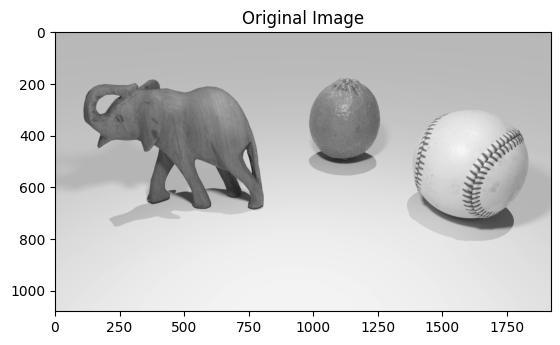

In [86]:
# Load in the noiseless image
img = cv2.imread('simulated_data/gt_simulated.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float64)
img = normalize_2D(img)

imshow(img, "Original Image")

Load the noisy simulated image dataset

(10, 1080, 1920)
PSNR Noisy Image: 19.223955151460263


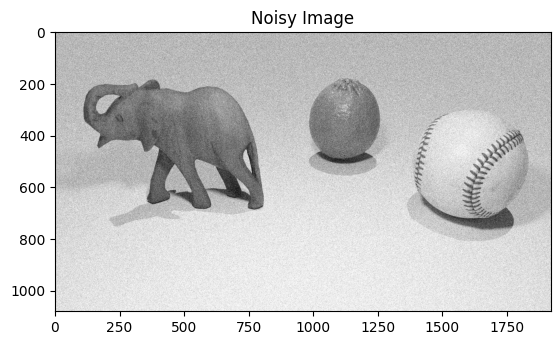

In [87]:
img_stack = np.load("simulated_data/img_noisy_stack.npy")

print(img_stack.shape)
[C, H, W] = img_stack.shape

imshow(img_stack[C-1,:,:], "Noisy Image")
print('PSNR Noisy Image:', psnr(img,normalize_2D(img_stack[2,:,:].squeeze())))

## Denoising by Averaging

PSNR Avg Image: 28.381494360374546


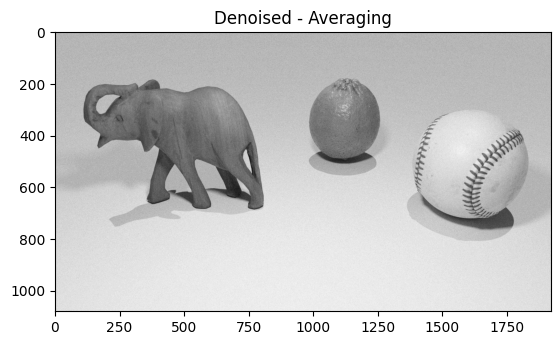

In [88]:
def denoise_avg(img_stack):
  '''
  TODO:
  Implement denoising by averaging
  across the full image stack,
  and uncomment the last line
  '''
  img_avg = np.mean(img_stack, axis=0)

  return img_avg

X_avg = denoise_avg(img_stack)
imshow(X_avg, "Denoised - Averaging")
print('PSNR Avg Image:', psnr(img,normalize_2D(X_avg.squeeze())))



(10, 1080, 1920) (1080, 1920)
PSNR Block Avg Image: 30.379311437115785


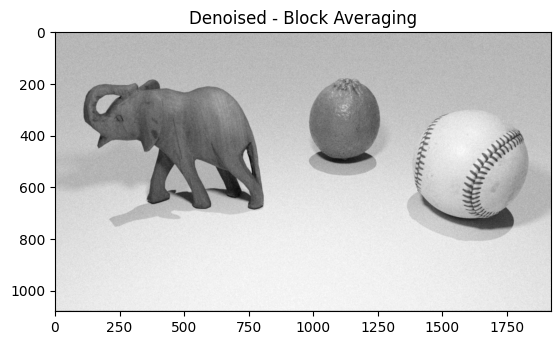

In [89]:
# This implements linear filtering using a block size
def linear_filt_avg(Y, block_sz):
  '''
  TODO:
  This program implements linear filtering by averaging blocks within
  a noisy image stack.
  Y = noisy image stack of size [C,H,W]
  block_sz = block size that will be averaged over [k,m,n]
  For each image pixel, assign the average value of the block around it
  '''
  # implement fast convolution with fft in numpy
  # set up a boxcar filter as conv with 1/kmn weights
  box_filter = np.ones(shape=block_sz) * 1/np.prod(block_sz)
  img_avg = fftconvolve(Y, box_filter, mode='same')
  # since using "same" results in the same dimensions,
  # we take the center image.

  return img_avg[img_avg.shape[0]//2]

'''
TODO:
Play around with the block size
to get a good PSNR of the denoised image
'''
block_size = [int(C/1.5), 3, 3]
# make sure to explain/motivate this

X_block_avg = linear_filt_avg(img_stack, block_size)
print(img_stack.shape, X_block_avg.shape)
imshow(X_block_avg, "Denoised - Block Averaging")
print('PSNR Block Avg Image:', psnr(img,normalize_2D(X_block_avg.squeeze())))

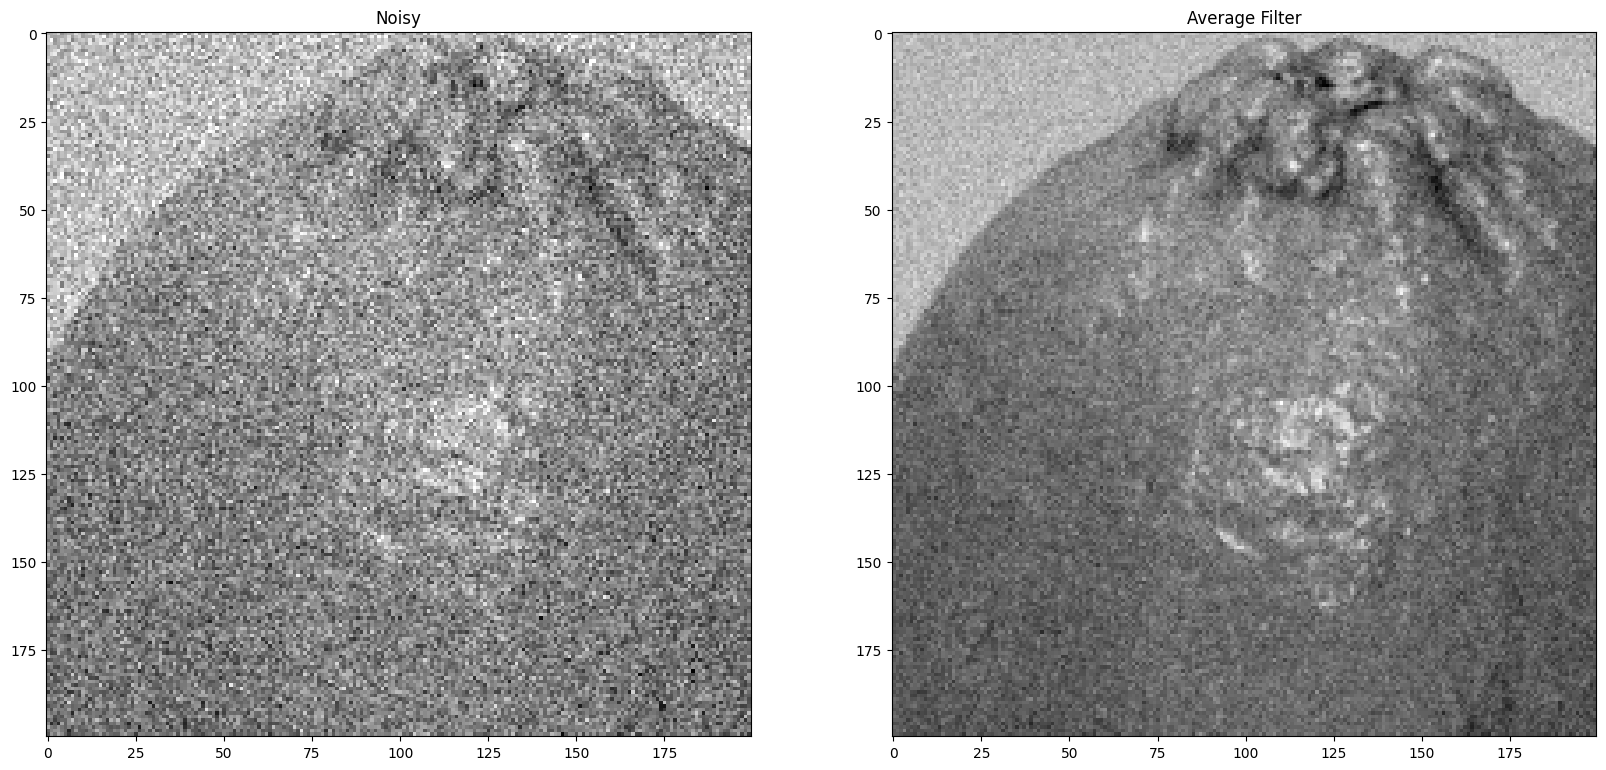

In [90]:
# Lime
h1 = 180; h2 = h1 + 200
w1 = 1000; w2 = w1 + 200
rect1 = [h1, h2, w1, w2]
imshowComparison(img_stack[C-1,:,:], X_avg, rect1, "Noisy", "Average Filter")

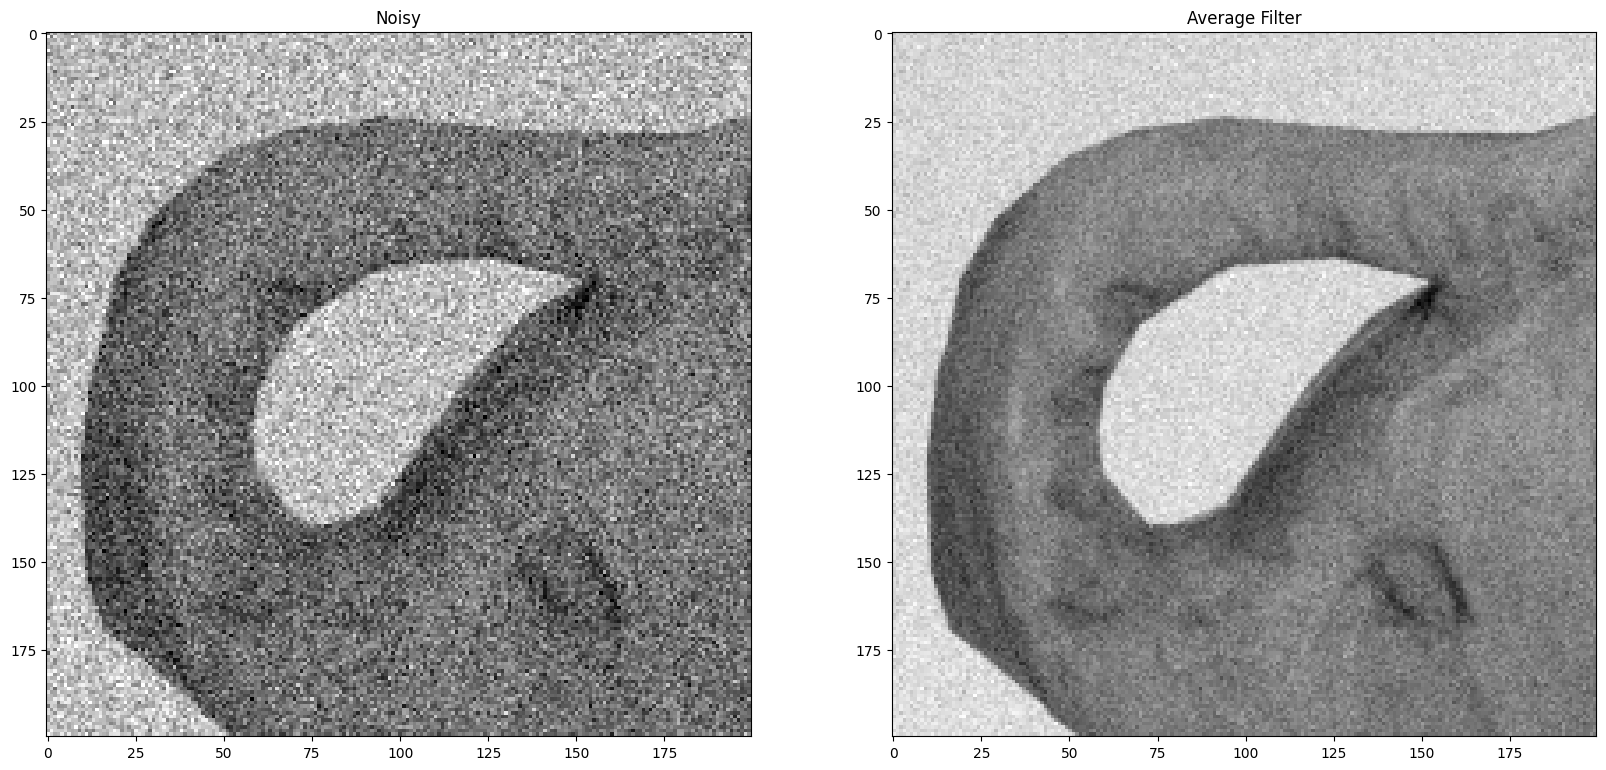

In [91]:
# Elephant
h1 = 180; h2 = h1 + 200
w1 = 100; w2 = w1 + 200
rect1 = [h1, h2, w1, w2]
imshowComparison(img_stack[C-1,:,:], X_avg, rect1, "Noisy", "Average Filter")

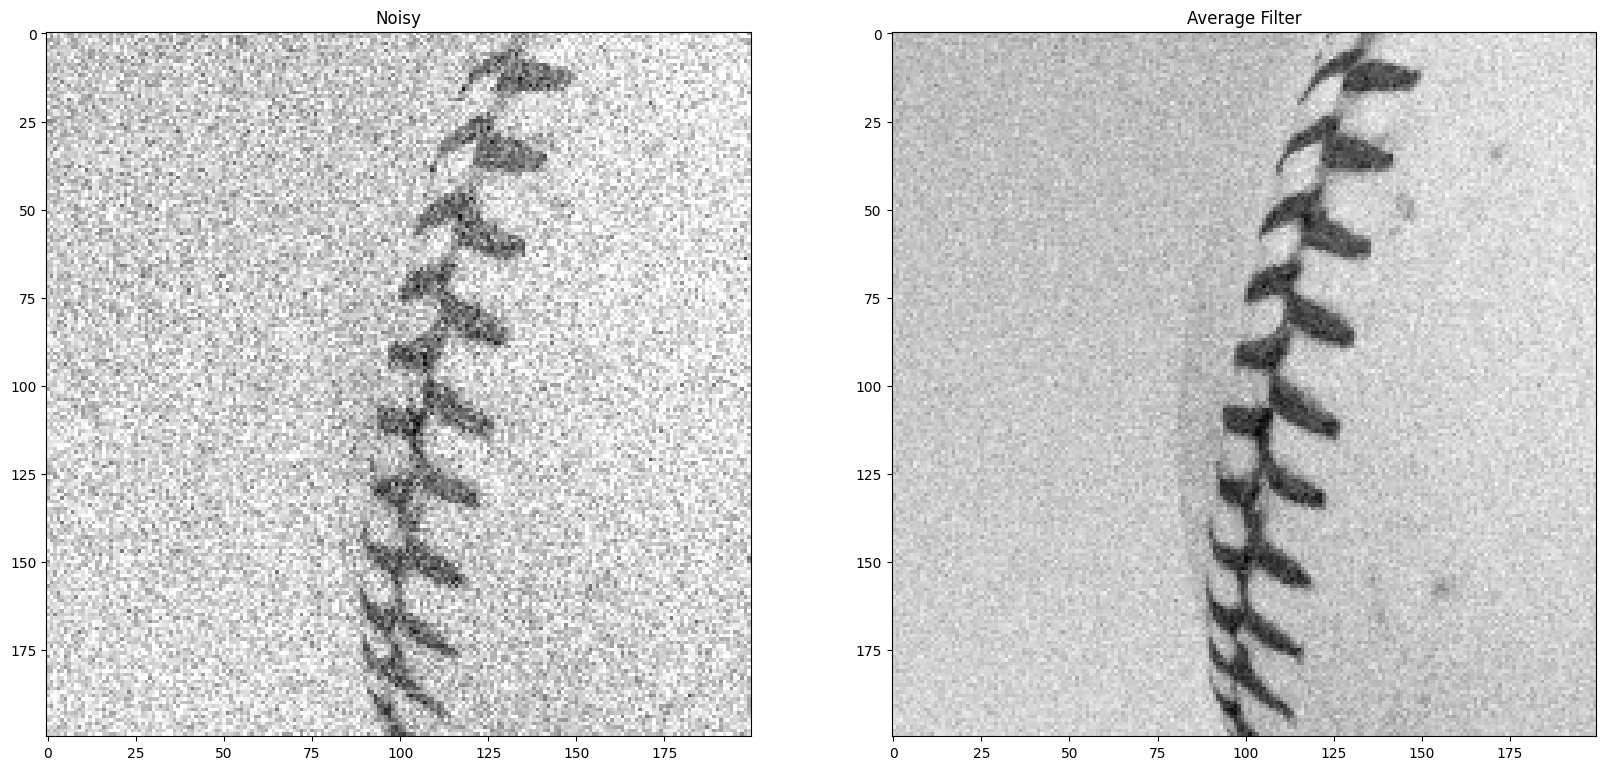

In [92]:
# Ball
h1 = 400; h2 = h1 + 200
w1 = 1300; w2 = w1 + 200
rect1 = [h1, h2, w1, w2]
imshowComparison(img_stack[C-1,:,:], X_avg, rect1, "Noisy", "Average Filter")

##  Denoising by Median filtering

PSNR Median Image: 27.308331157628555


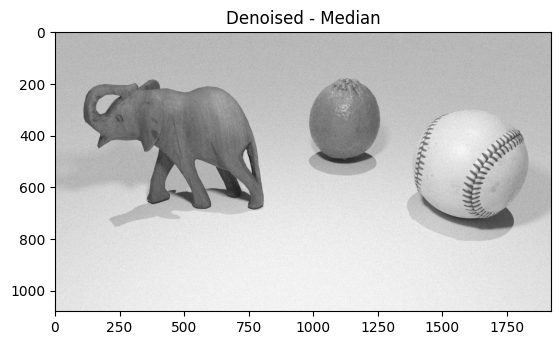

In [93]:
def denoise_median(img_stack):
  '''
  TODO:
  Implement median filtering
  across pixels to denoise,
  and uncomment the last line
  '''
  # in a similar analog to mean filtering,
  # only makes sense to median across the C dimension
  img_median = np.median(img_stack, axis=0)

  return img_median

X_median = denoise_median(img_stack)
imshow(X_median, "Denoised - Median")
print('PSNR Median Image:', psnr(img,normalize_2D(X_median.squeeze())))

PSNR Block Median Image: 30.260248619886518


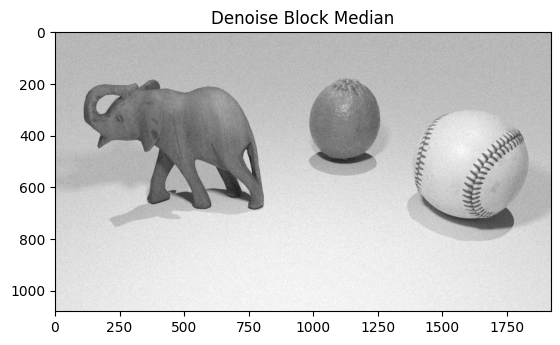

In [94]:
# This implements nonlinear filtering using a block size
def nonlinear_filt_median(Y, block_sz):
  '''
  TODO:
  This program implements nonlinear filtering by taking median of blocks within
  a noisy image stack.
  Y = noisy image stack of size [C,H,W]
  block_sz = block size that will have median taken [k,m,n]
  For each image pixel, assign the median value of the block around it
  '''
  Y_ext = np.lib.pad(Y,((0, 0),(block_sz[1],block_sz[2]),(block_sz[1],block_sz[2])),'reflect')
  img_median = np.zeros(Y.shape[1:])
  for i in range(block_sz[1], block_sz[1] + Y.shape[1]):
    for j in range(block_sz[2], block_sz[2] + Y.shape[2]):
      img_median[i - block_sz[1], j - block_sz[2]] = np.median(Y_ext[:block_sz[0], i - block_sz[1]:i + block_sz[1],
                                                                     j - block_sz[2]:j + block_sz[2]])

  return img_median

'''
TODO:
Play around with the block size
to get a good PSNR of the denoised image
'''
block_size = [int(C/1.5), 1, 1]

X_median = nonlinear_filt_median(img_stack, block_size)
imshow(X_median, "Denoise Block Median")
print('PSNR Block Median Image:', psnr(img,normalize_2D(X_median.squeeze())))

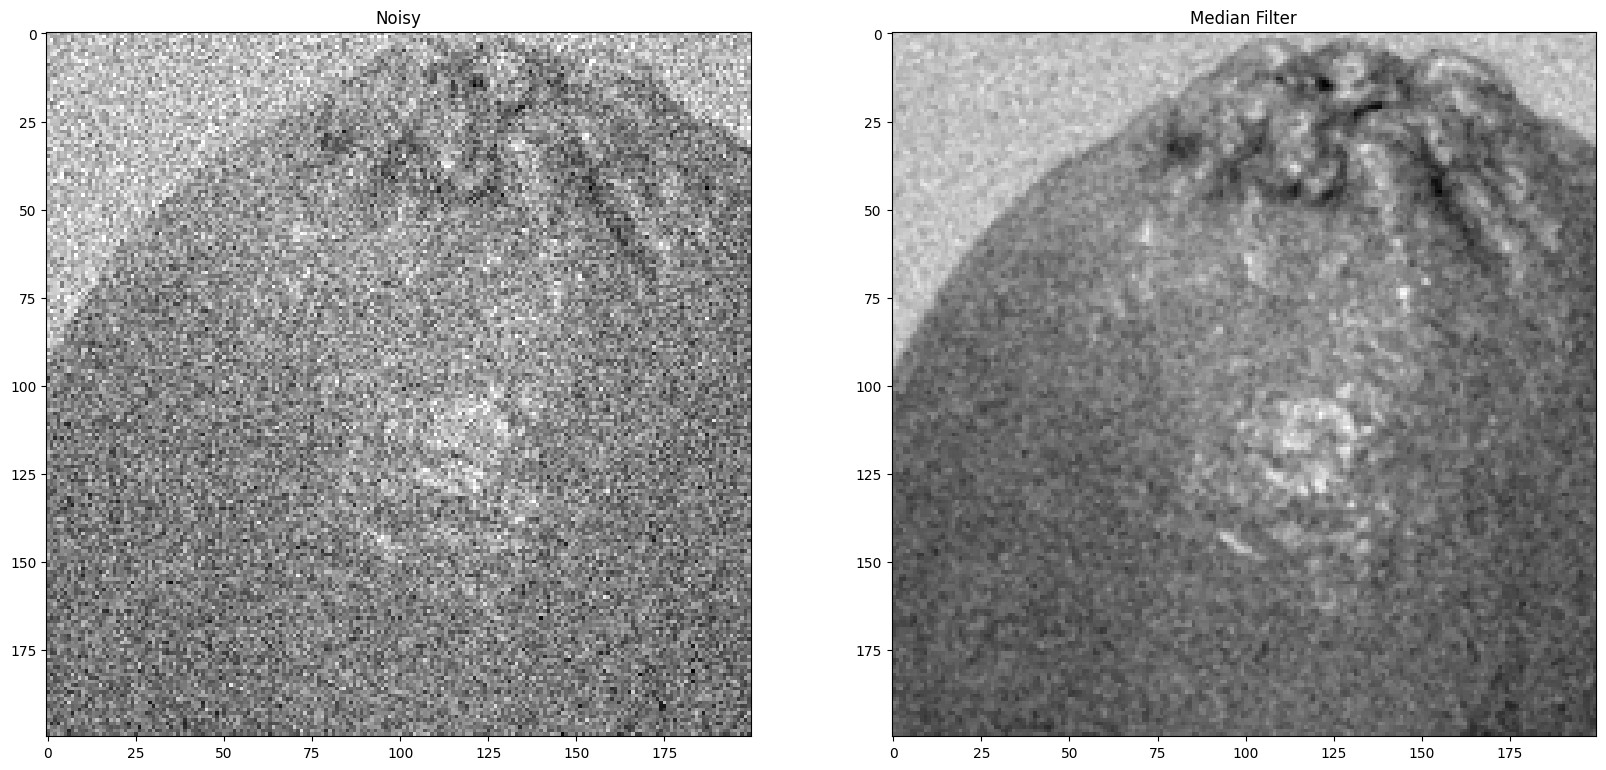

In [95]:
# Lime
h1 = 180; h2 = h1 + 200
w1 = 1000; w2 = w1 + 200
rect1 = [h1, h2, w1, w2]
imshowComparison(img_stack[C-1,:,:], X_median, rect1, "Noisy", "Median Filter")

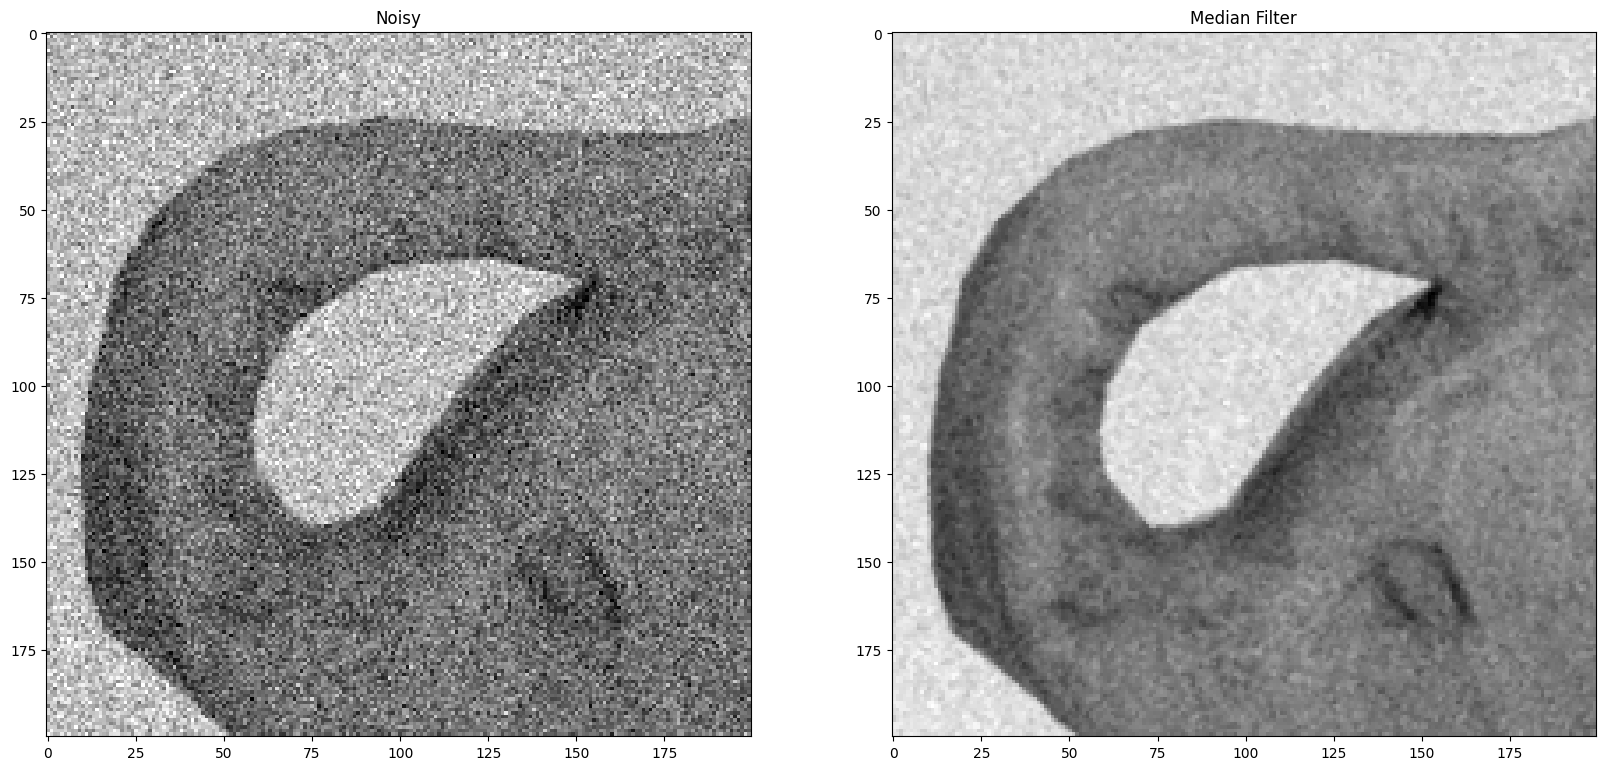

In [96]:
# Elephant
h1 = 180; h2 = h1 + 200
w1 = 100; w2 = w1 + 200
rect1 = [h1, h2, w1, w2]
imshowComparison(img_stack[C-1,:,:], X_median, rect1, "Noisy", "Median Filter")

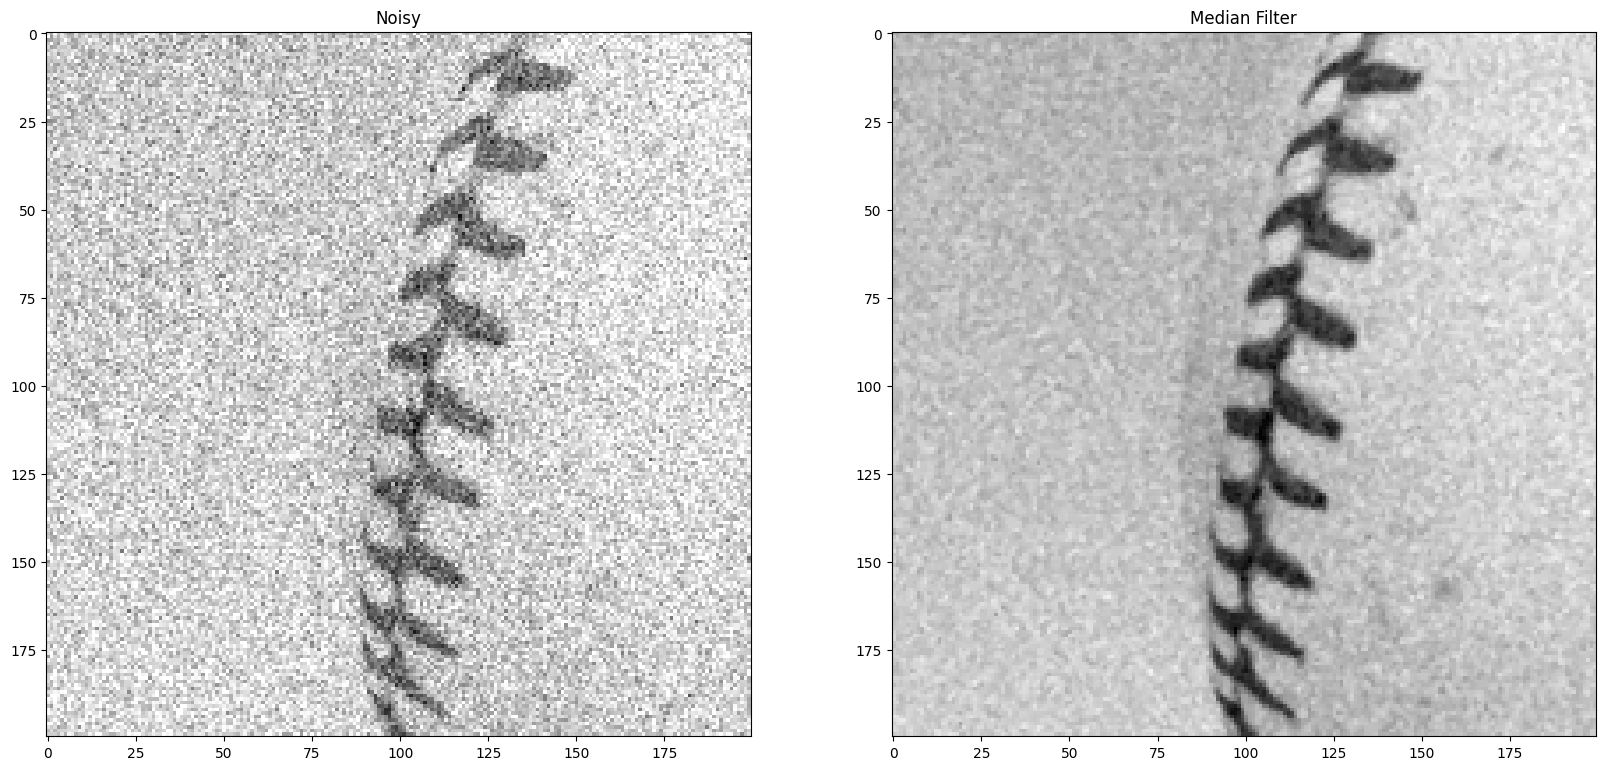

In [97]:
# Ball
h1 = 400; h2 = h1 + 200
w1 = 1300; w2 = w1 + 200
rect1 = [h1, h2, w1, w2]
imshowComparison(img_stack[C-1,:,:], X_median, rect1, "Noisy", "Median Filter")


---


For the remaining tasks, we encourage you to choose an orthogonal transform, let's call it *OT* for future reference. This could be a Discrete Cosine Transform (DCT), or wavelet transform, or something else, be creative!

The inverse *OT* is then the corresponding inverse operation.
- Example: inverse DCT for DCT.

We have given implementation for DCT in the initial code block as reference if you need it.

---


# Denoising using an orthogonal transform (OT) method


Refer to the HW PDF document, Section on "Compressed Sensing Denoising" for this part

This part refers to the paper ["Improved Wavelet Denoising via Empirical Wiener Filtering"](https://scholarship.rice.edu/bitstream/handle/1911/19895/Gha1997Jul5ImprovedW.PDF?sequence=1&isAllowed=y) by Richard G. Baraniuk et al.

## Part 1: Apply on 2D

This approach is just applied to a single noisy image to start off

In [98]:
print(pywt.wavelist())

['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'cgau1', 'cgau2', 'cgau3', 'cgau4', 'cgau5', 'cgau6', 'cgau7', 'cgau8', 'cmor', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'fbsp', 'gaus1', 'gaus2', 'gaus3', 'gaus4', 'gaus5', 'gaus6', 'gaus7', 'gaus8', 'haar', 'mexh', 'morl', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'shan', 'sym2', 'sym3

In [99]:
def wavelet2D(x):
  return pywt.wavedec2(x, 'db4')

def iwavelet2D(x):
  return pywt.waverec2(x, 'db4')

def wavelet2D_2(x):
  return pywt.wavedec2(x, 'db2')

def iwavelet2D_2(x):
  return pywt.waverec2(x, 'db2')

def wavelet2D_3(x):
  return pywt.wavedec2(x, 'db1')

def iwavelet2D_3(x):
  return pywt.waverec2(x, 'db1')

# seems like we have to write a diff method for each OT? or else this following method gets too bloated?
def unravel_wavecoeff(x):
  outputarr = []
  # input: list of buncha different dimension numpy arrays
  # print("x", len(x))
  for arr in x:
    # print("arr", len(arr))
    for num in arr:
      # print("num", len(num))
      for thing in num:
        # we reach numbers only with cA (first array)
        if isinstance(thing, np.float64):
          outputarr.append(thing)
        else:
          for number in thing:
            outputarr.append(number)
  outputarr = np.asarray(outputarr)
  print(outputarr.shape)
  return outputarr

def replace_wiener(old_coeffs, sigma_estimate):
  new_coeffs = copy.deepcopy(old_coeffs)
  for ind in range(len(new_coeffs)):
    if isinstance(new_coeffs[ind], np.float64):
      new_coeffs[ind] = new_coeffs[ind]*new_coeffs[ind]**2/(new_coeffs[ind]**2 + sigma_estimate**2)
    else:
      for ind2 in range(len(new_coeffs[ind])):
        if isinstance(new_coeffs[ind][ind2], np.float64):
          new_coeffs[ind][ind2] = new_coeffs[ind][ind2]*new_coeffs[ind][ind2]**2/(new_coeffs[ind][ind2]**2 + sigma_estimate**2)
        else:
          for ind3 in range(len(new_coeffs[ind][ind2])):
            if isinstance(new_coeffs[ind][ind2][ind3], np.float64):
              new_coeffs[ind][ind2][ind3] = new_coeffs[ind][ind2][ind3]*new_coeffs[ind][ind2][ind3]**2/(
                  new_coeffs[ind][ind2][ind3]**2 + sigma_estimate**2)
            else:
              for ind4 in range(len(new_coeffs[ind][ind2][ind3])):
                if isinstance(new_coeffs[ind][ind2][ind3][ind4], np.float64):
                  new_coeffs[ind][ind2][ind3][ind4] = new_coeffs[ind][ind2][ind3][ind4]*new_coeffs[ind][ind2][ind3][ind4]**2/(
                      new_coeffs[ind][ind2][ind3][ind4]**2 + sigma_estimate**2)
  return new_coeffs

def chop_wiener(old_coeffs, threshold):
  new_coeffs = copy.deepcopy(old_coeffs)
  for ind in range(len(new_coeffs)):
    if isinstance(new_coeffs[ind], np.float64):
      new_coeffs[ind] = new_coeffs[ind] if new_coeffs[ind] > threshold else 0
    else:
      for ind2 in range(len(new_coeffs[ind])):
        if isinstance(new_coeffs[ind][ind2], np.float64):
          new_coeffs[ind][ind2] = new_coeffs[ind][ind2] if new_coeffs[ind][ind2] > threshold else 0
        else:
          for ind3 in range(len(new_coeffs[ind][ind2])):
            if isinstance(new_coeffs[ind][ind2][ind3], np.float64):
              new_coeffs[ind][ind2][ind3] = new_coeffs[ind][ind2][ind3] if new_coeffs[ind][ind2][ind3] > threshold else 0
            else:
              for ind4 in range(len(new_coeffs[ind][ind2][ind3])):
                if isinstance(new_coeffs[ind][ind2][ind3][ind4], np.float64):
                  new_coeffs[ind][ind2][ind3][ind4] = new_coeffs[ind][ind2][ind3][ind4] if new_coeffs[ind][ind2][ind3][ind4] > threshold else 0
  return new_coeffs

(2112546,)
(2112546,) 2073600
initial sigma estimate: 0.5006733987581435


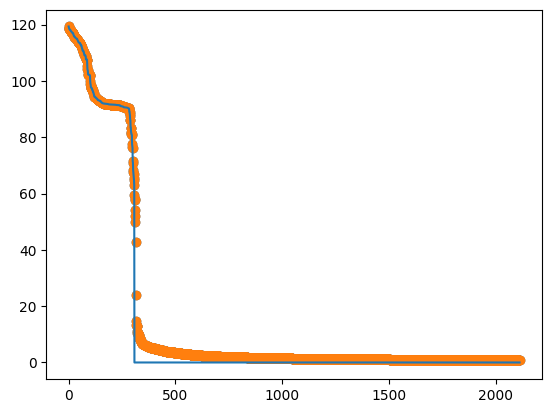

PSNR OT denoised Image: 29.918085781954016


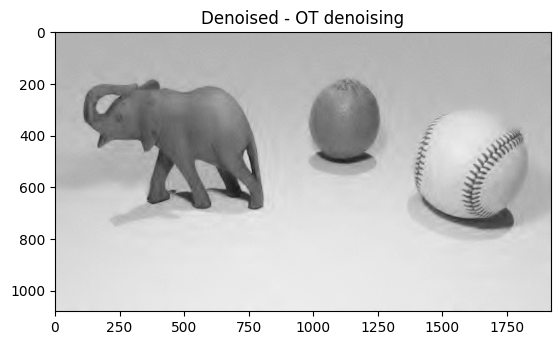

In [101]:
def ot_denoising(img, transform=dct2D, inv_transform=idct2D, additional_parameters_if_required=None, percent_lo=0.0025, percent_hi=0.5):
  '''
  TODO:
  Implement the following -
  1. Apply the OT
  2. Use a transform of your choice
  3. Apply Inverse OT to go back to image domain and return
  Uncomment the last line to return
  '''
  # img = normalize_2D(img)
  frac = 1000 # 10000*5 for dct, 1000 for db4
  # percent_lo = 0.0025
  # 0 gives clearer img, lower snr. 0.00025 gives blurrier img but better snr with dct
  # 0.0025 for db4 on default settings gives 29.49 psnr, ringing artifacts around the objects, hi 0.25
  # lo 0.0025 hi 0.01 for db8 gives 23 psnr
  # percent_hi = 0.5#0.5**2
  # could use an integral to determine a set % of power for these thresholds using parseval's thm
  # just use DCT for now
  # apply OT
  img_ot = transform(img)
  img_ot_copy = copy.deepcopy(img_ot)
  if transform == wavelet2D:
    img_ot = unravel_wavecoeff(img_ot)
  # print(img_ot)
  # print()
  #print(img_ot.shape)

  # sigma should be around 0.2-0.4

  # then sort eigenvalues
  eig_sorted = np.flip(np.sort(np.ndarray.flatten(np.abs(img_ot))))
  print(eig_sorted.shape, 1080*1920)
  plt.scatter(range(eig_sorted.shape[0]//frac), eig_sorted[:eig_sorted.shape[0]//frac])

  # we can use the 3rd and 4th standard deviations to determine these thresholds
  # can chop
  thresh_lo = percent_lo*eig_sorted[0]
  thresh_hi = percent_hi*eig_sorted[0]
  chopped = np.where(eig_sorted > thresh_lo, eig_sorted, 0)
  chopped2 = np.where(chopped > thresh_hi, chopped, 0)
  plt.scatter(range(eig_sorted.shape[0]//frac), chopped[:eig_sorted.shape[0]//frac])
  plt.plot(range(eig_sorted.shape[0]//frac), chopped2[:eig_sorted.shape[0]//frac])
  # print(chopped, thresh_lo)



  # === double threshold richb algo ===
  # can use 2 thresholds to approximate non-zero low coefficients, average them to get variance estimate for chop
  chopdiff = chopped - chopped2
  mean_array = chopdiff[chopdiff != 0]
  sigma_estimate = np.mean(mean_array)
  print("initial sigma estimate:", sigma_estimate)

  # here, after we get sigma estimate, we use the chopped signal, transform it back,
  # and go for round 2 with a rotated transform
  # then add the eligible coeffs to averaging list to be averaged for final sigma estimation
  # the final wiener filter is still applied on full coefficients

  # find a rotated transform
  # we need to get the transform's matrix and raise it to the -.1^th power

  # maybe we do the same but with smaller scale instead -- to squeeze out the noise in that ringing artifact
  # chop


  # # === SECOND TRANSFORM STARTS HERE===
  # # print(img_ot_copy)
  # chopped_inorder = chop_wiener(img_ot_copy, thresh_hi)
  # # print(img_ot_copy)
  # # transform back and then transform into the 2nd transform
  # temp_img = iwavelet2D(chopped_inorder)

  # # transform with 2nd transform
  # img_ot_2 = wavelet2D_2(temp_img)
  # img_ot_2_copy = copy.deepcopy(img_ot_2)
  # if transform == wavelet2D:
  #   img_ot_2 = unravel_wavecoeff(img_ot_2)
  # # perform double thresholding once again
  # # sort eigenvalues
  # eig_sorted_2 = np.flip(np.sort(np.ndarray.flatten(np.abs(img_ot_2))))
  # print(eig_sorted_2.shape, 1080*1920)
  # plt.scatter(range(eig_sorted_2.shape[0]//frac), eig_sorted_2[:eig_sorted_2.shape[0]//frac])

  # # we can use the 3rd and 4th standard deviations to determine these thresholds
  # # can chop
  # thresh_lo_2 = percent_lo*eig_sorted_2[0]
  # thresh_hi_2 = percent_hi*eig_sorted_2[0]
  # chopped_2 = np.where(eig_sorted_2 > thresh_lo_2, eig_sorted_2, 0)
  # chopped2_2 = np.where(chopped_2 > thresh_hi_2, chopped_2, 0)
  # plt.scatter(range(eig_sorted_2.shape[0]//frac), chopped_2[:eig_sorted_2.shape[0]//frac])
  # plt.plot(range(eig_sorted_2.shape[0]//frac), chopped2_2[:eig_sorted_2.shape[0]//frac])
  # # print(chopped, thresh_lo)

  # # === double threshold richb algo ===
  # # can use 2 thresholds to approximate non-zero low coefficients, average them to get variance estimate for chop
  # chopdiff_2 = chopped_2 - chopped2_2
  # mean_array_2 = chopdiff_2[chopdiff_2 != 0]
  # sigma_estimate_2 = (np.sum(mean_array) + np.sum(mean_array_2))/(len(mean_array) + len(mean_array_2))
  # print("updated sigma estimate:", sigma_estimate_2)
  # # === END SECOND TRANSFORM ===


  # # === THIRD TRANSFORM STARTS HERE===
  # # print(img_ot_copy)
  # chopped_inorder = chop_wiener(img_ot_2_copy, thresh_hi_2)
  # # print(img_ot_copy)
  # # transform back and then transform into the 2nd transform
  # temp_img_2 = iwavelet2D_2(chopped_inorder)

  # # transform with 3rd transform
  # img_ot_3 = wavelet2D_3(temp_img_2)
  # #img_ot_2_copy = img_ot_2.copy()
  # if transform == wavelet2D:
  #   img_ot_3 = unravel_wavecoeff(img_ot_3)
  # # perform double thresholding once again
  # # sort eigenvalues
  # eig_sorted_3 = np.flip(np.sort(np.ndarray.flatten(np.abs(img_ot_3))))
  # print(eig_sorted_3.shape, 1080*1920)
  # plt.scatter(range(eig_sorted_3.shape[0]//frac), eig_sorted_3[:eig_sorted_3.shape[0]//frac])

  # # we can use the 3rd and 4th standard deviations to determine these thresholds
  # # can chop
  # thresh_lo_3 = percent_lo*eig_sorted_3[0]
  # thresh_hi_3 = percent_hi*eig_sorted_3[0]
  # chopped_3 = np.where(eig_sorted_3 > thresh_lo_3, eig_sorted_3, 0)
  # chopped2_3 = np.where(chopped_3 > thresh_hi_3, chopped_3, 0)
  # plt.scatter(range(eig_sorted_3.shape[0]//frac), chopped_3[:eig_sorted_3.shape[0]//frac])
  # plt.plot(range(eig_sorted_3.shape[0]//frac), chopped2_3[:eig_sorted_3.shape[0]//frac])
  # # print(chopped, thresh_lo)

  # # === double threshold richb algo ===
  # # can use 2 thresholds to approximate non-zero low coefficients, average them to get variance estimate for chop
  # chopdiff_3 = chopped_3 - chopped2_3
  # mean_array_3 = chopdiff_3[chopdiff_3 != 0]
  # sigma_estimate_3 = (np.sum(mean_array) + np.sum(mean_array_2) + np.sum(mean_array_3))/(len(mean_array) + len(mean_array_2) + len(mean_array_3))
  # print("updated sigma estimate:", sigma_estimate_3)
  # # === END THIRD TRANSFORM ===




  # apply wiener filter on eigens
  # test -- crude method by just removing some
  new_coeffs = img_ot_copy.copy()
  new_coeffs = replace_wiener(new_coeffs, sigma_estimate)
  # === end of algo ===



  # === this gives 22 psnr but rly bad image -- this is hard thresholding ===
  # new_coeffs = np.where(np.abs(img_ot) > thresh_lo*8, img_ot, 0)
  # print(new_coeffs)
  # === end of hard thresholding ===

  # put it back
  # inv dct requires at least 2 nonzero coefficients, since there's max - min in denominator
  img_ot_denoised = inv_transform(new_coeffs)

  # once we put it back, we can rotate our transform some degrees between space domain and transform domain
  # set the same hard 2nd threshold, then add the nonzero points to the sigma estimate average

  # then use new sigma estimate for 2nd wiener filter -- can repeat n times

  plt.show()

  return img_ot_denoised

# take a single noisy image
img_noisy0 = img_stack[0,:,:].squeeze()

'''
TODO:
Play around with any parameters your algorithm might
have to get a good PSNR
'''
X_ot = ot_denoising(img_noisy0, wavelet2D, iwavelet2D)

imshow(X_ot, 'Denoised - OT denoising')
print('PSNR OT denoised Image:', psnr(img,normalize_2D(X_ot)))

# notice:
# using db4 gives better psnr (still < mean) but using db2 gives less speckle and artifacts

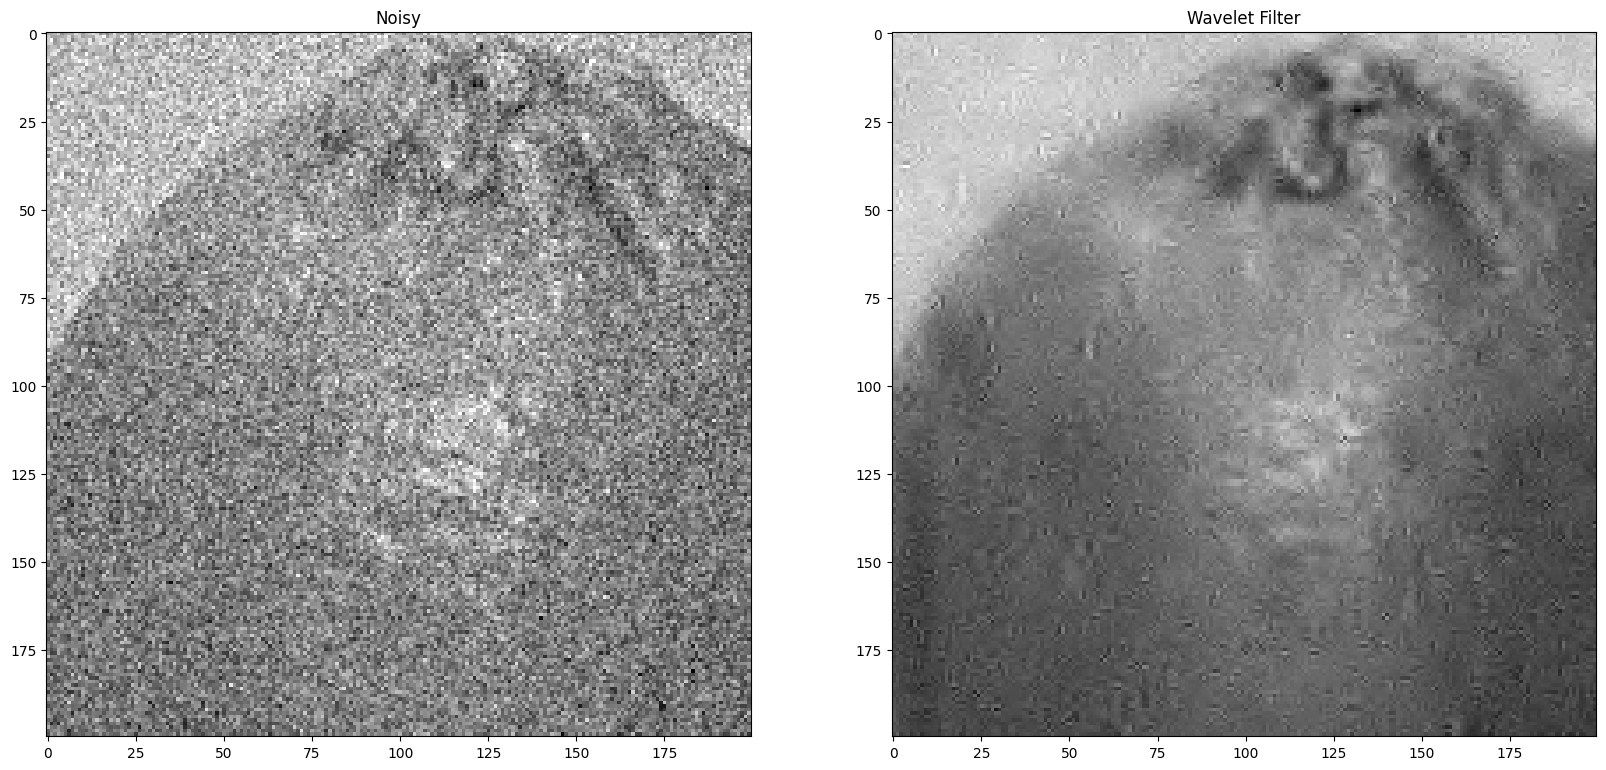

In [105]:
# Lime
h1 = 180; h2 = h1 + 200
w1 = 1000; w2 = w1 + 200
rect1 = [h1, h2, w1, w2]
imshowComparison(img_stack[C-1,:,:], X_ot, rect1, "Noisy", "Wavelet Filter")

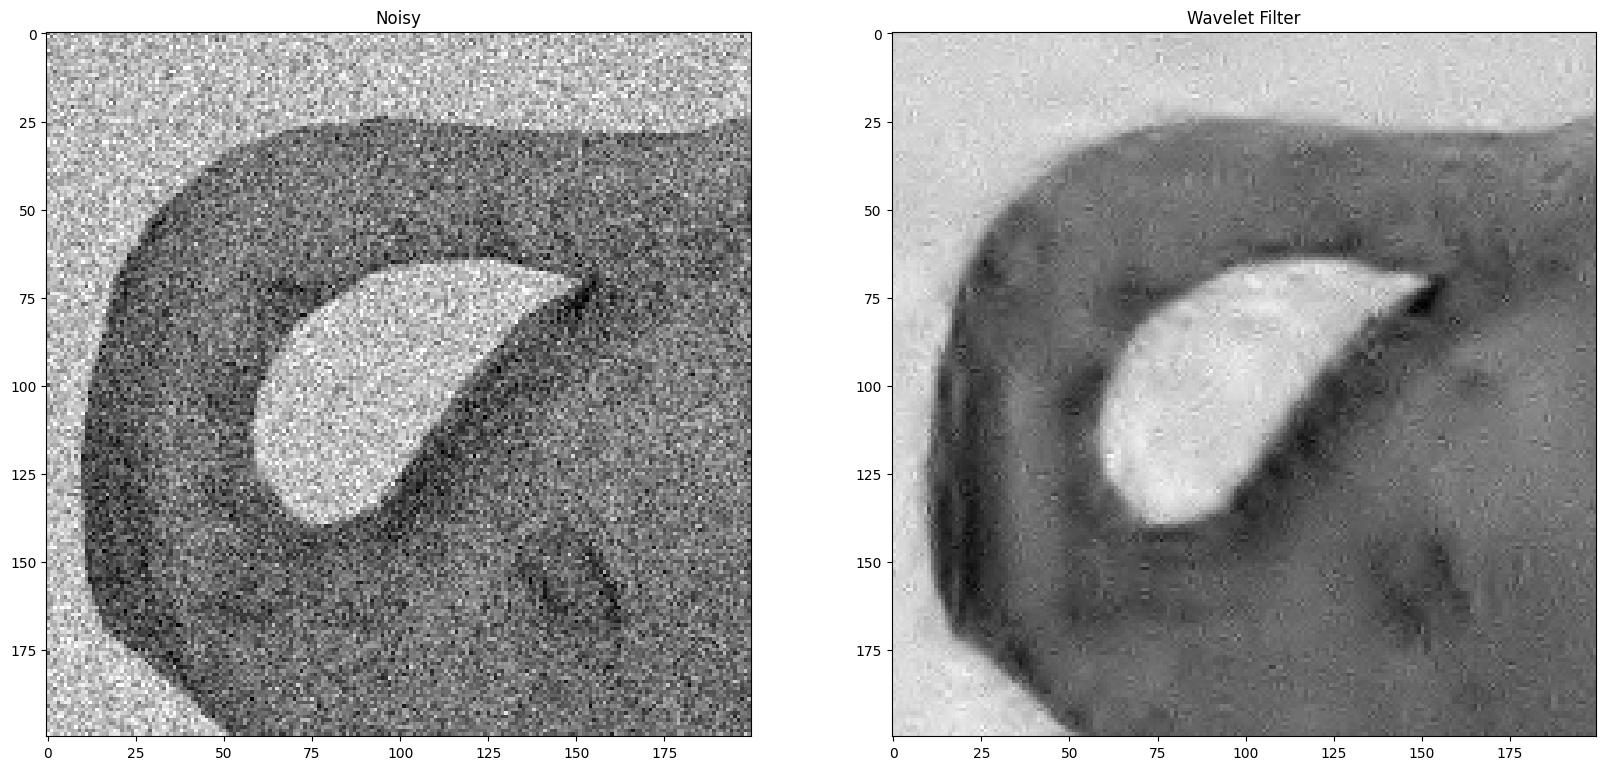

In [106]:
# Elephant
h1 = 180; h2 = h1 + 200
w1 = 100; w2 = w1 + 200
rect1 = [h1, h2, w1, w2]
imshowComparison(img_stack[C-1,:,:], X_ot, rect1, "Noisy", "Wavelet Filter")

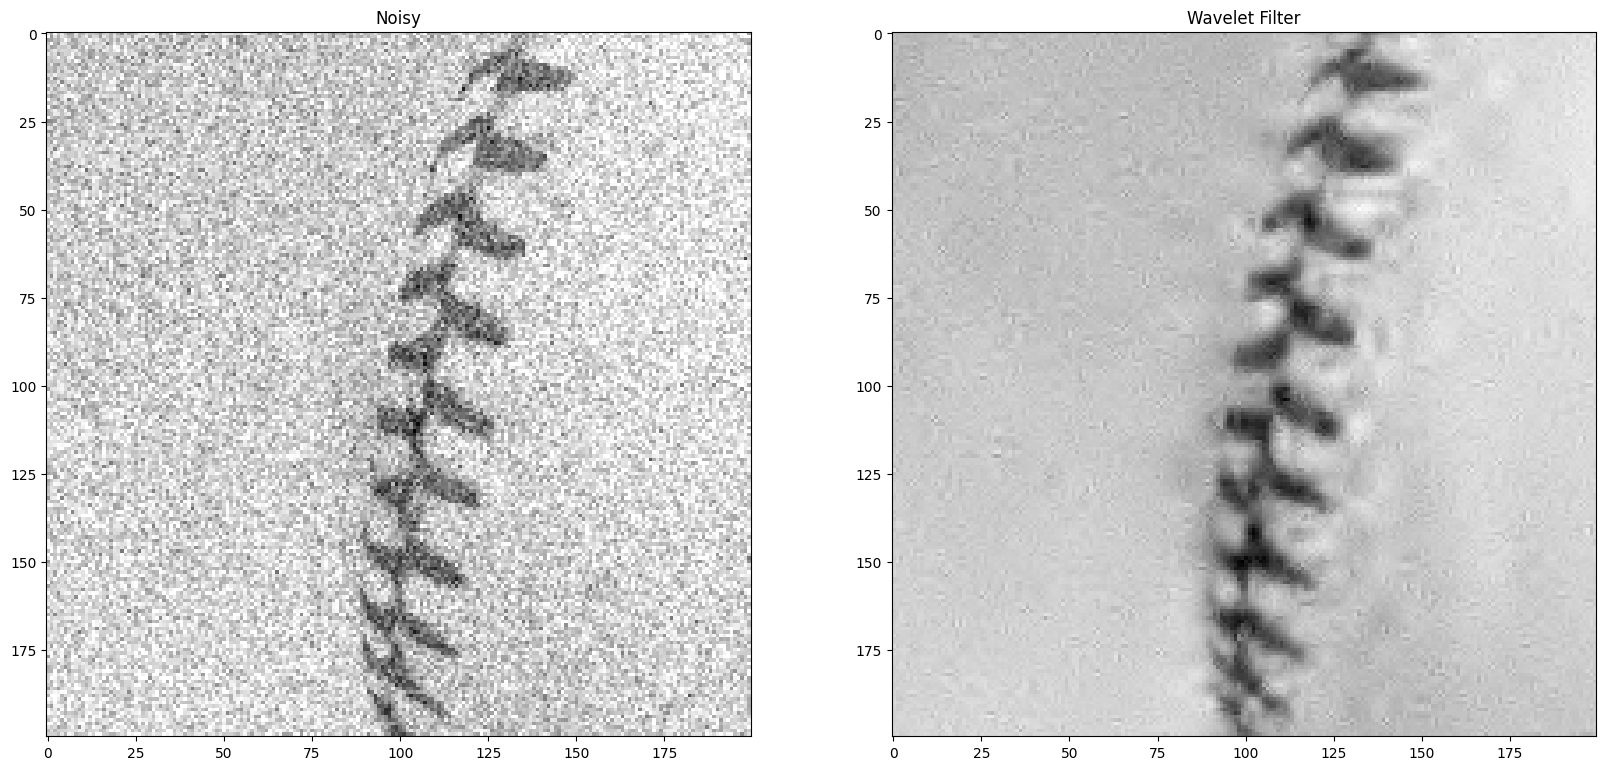

In [107]:
# Ball
h1 = 400; h2 = h1 + 200
w1 = 1300; w2 = w1 + 200
rect1 = [h1, h2, w1, w2]
imshowComparison(img_stack[C-1,:,:], X_ot, rect1, "Noisy", "Wavelet Filter")

# Using the full stack of noisy images

## Part 2: Apply the above implementation but for 3D this time

Modify your previous implementation to account for a 3 dimensional stack instead of a single image.
Note: Modify the OT function from OT2D to OT3D and correspondingly its inverse, if needed. Also remember that the final output of the function should be a 2D image.

In [59]:
def wavelet3D(x):
  return pywt.dwtn(x, 'db4')

def iwavelet3D(x):
  return pywt.idwtn(x, 'db4')

def wavelet3D_2(x):
  return pywt.dwtn(x, 'db2')

def iwavelet3D_2(x):
  return pywt.idwtn(x, 'db2')

def wavelet3D_3(x):
  return pywt.dwtn(x, 'db1')

def iwavelet3D_3(x):
  return pywt.idwtn(x, 'db1')

def unravel_wavecoeff_3d(data_dict):
    num_list = []
    for key, array in data_dict.items():
        # Flatten the nested array and extend the num_list
        num_list.extend(array.flatten())
    return num_list

def replace_wiener_3d(data_dict, sigma_estimate):
    # Create a new dictionary to store arrays with zeros
    zeroed_dict = {}

    # Iterate through the keys in the input dictionary
    for key, array in data_dict.items():
        # Create a new array of the same shape as the original with all zeros
        new_array = np.array([i**2/(i**2 + sigma_estimate**2) for i in array])

        # Add the zeroed array to the new dictionary
        zeroed_dict[key] = new_array

    return zeroed_dict

def chop_wiener_3d(data_dict, threshold):
    # Create a new dictionary to store arrays with zeros
    zeroed_dict = {}

    # Iterate through the keys in the input dictionary
    for key, array in data_dict.items():
        # Create a new array of the same shape as the original with all zeros
        zeroed_array = np.where(array > 0, array, 0)

        # Add the zeroed array to the new dictionary
        zeroed_dict[key] = zeroed_array

    return zeroed_dict

In [60]:
def ot_denoising3D(img_stack, transform=dct3D, inv_transform=idct3D, additional_parameters_if_required=None, percent_lo=0.25, percent_hi=1):
  '''
  TODO:
  Implement the following -
  1. Apply the OT3D
  2. Use a transform of your choice
  3. Apply Inverse OT to go back to image domain and return
  Uncomment the last line to return
  '''
  # same algo but 3d
  # img = normalize_2D(img)
  frac = 1000 # 10000*5 for dct, 1000 for db4
  # percent_lo = 0.25
  # 0 gives clearer img, lower snr. 0.00025 gives blurrier img but better snr with dct
  # 0.0025 for db4 on default settings gives 29.49 psnr, ringing artifacts around the objects, hi 0.25
  # lo 0.0025 hi 0.01 for db8 gives 23 psnr
  # percent_hi = 1
  # could use an integral to determine a set % of power for these thresholds using parseval's thm
  # just use DCT for now
  # apply OT
  img_ot = transform(img_stack)
  # print(img_ot)
  img_ot_copy = copy.deepcopy(img_ot)
  if transform == wavelet3D:
    img_ot = unravel_wavecoeff_3d(img_ot)
  # print(img_ot)
  # print()
  #print(img_ot.shape)

  # sigma should be around 0.2-0.4

  # then sort eigenvalues
  eig_sorted = np.flip(np.sort(np.ndarray.flatten(np.abs(img_ot))))
  print(eig_sorted.shape, 1080*1920)
  # plt.scatter(range(eig_sorted.shape[0]//frac), eig_sorted[:eig_sorted.shape[0]//frac])

  # we can use the 3rd and 4th standard deviations or some statistical/energy threshold to determine these thresholds
  # can chop
  thresh_lo = percent_lo*eig_sorted[0]
  thresh_hi = percent_hi*eig_sorted[0]
  chopped = np.where(eig_sorted > thresh_lo, eig_sorted, 0)
  chopped2 = np.where(chopped > thresh_hi, chopped, 0)
  # plt.scatter(range(eig_sorted.shape[0]//frac), chopped[:eig_sorted.shape[0]//frac])
  # plt.plot(range(eig_sorted.shape[0]//frac), chopped2[:eig_sorted.shape[0]//frac])
  # print(chopped, thresh_lo)



  # === double threshold richb algo ===
  # can use 2 thresholds to approximate non-zero low coefficients, average them to get variance estimate for chop
  chopdiff = chopped - chopped2
  mean_array = chopdiff[chopdiff != 0]
  sigma_estimate = np.mean(mean_array)
  print("initial sigma estimate:", sigma_estimate)


  '''SECOND AND THIRD TRANSFORMS --- RICHB'''
  # # === SECOND TRANSFORM STARTS HERE===
  # # print(img_ot_copy)
  # chopped_inorder = chop_wiener_3d(img_ot_copy, thresh_hi)
  # # print(img_ot_copy)
  # # transform back and then transform into the 2nd transform
  # temp_img = iwavelet3D(chopped_inorder)

  # # transform with 2nd transform
  # img_ot_2 = wavelet3D_2(temp_img)
  # img_ot_2_copy = copy.deepcopy(img_ot_2)
  # if transform == wavelet3D:
  #   img_ot_2 = unravel_wavecoeff_3d(img_ot_2)
  # # perform double thresholding once again
  # # sort eigenvalues
  # eig_sorted_2 = np.flip(np.sort(np.ndarray.flatten(np.abs(img_ot_2))))
  # print(eig_sorted_2.shape, 1080*1920)
  # plt.scatter(range(eig_sorted_2.shape[0]//frac), eig_sorted_2[:eig_sorted_2.shape[0]//frac])

  # # we can use the 3rd and 4th standard deviations to determine these thresholds
  # # can chop
  # thresh_lo_2 = percent_lo*eig_sorted_2[0]
  # thresh_hi_2 = percent_hi*eig_sorted_2[0]
  # chopped_2 = np.where(eig_sorted_2 > thresh_lo_2, eig_sorted_2, 0)
  # chopped2_2 = np.where(chopped_2 > thresh_hi_2, chopped_2, 0)
  # plt.scatter(range(eig_sorted_2.shape[0]//frac), chopped_2[:eig_sorted_2.shape[0]//frac])
  # plt.plot(range(eig_sorted_2.shape[0]//frac), chopped2_2[:eig_sorted_2.shape[0]//frac])
  # # print(chopped, thresh_lo)

  # # === double threshold richb algo ===
  # # can use 2 thresholds to approximate non-zero low coefficients, average them to get variance estimate for chop
  # chopdiff_2 = chopped_2 - chopped2_2
  # mean_array_2 = chopdiff_2[chopdiff_2 != 0]
  # sigma_estimate_2 = (np.sum(mean_array) + np.sum(mean_array_2))/(len(mean_array) + len(mean_array_2))
  # print("updated sigma estimate:", sigma_estimate_2)
  # # === END SECOND TRANSFORM ===


  # # === THIRD TRANSFORM STARTS HERE===
  # # print(img_ot_copy)
  # chopped_inorder = chop_wiener_3d(img_ot_2_copy, thresh_hi_2)
  # # print(img_ot_copy)
  # # transform back and then transform into the 2nd transform
  # temp_img_2 = iwavelet3D_2(chopped_inorder)

  # # transform with 3rd transform
  # img_ot_3 = wavelet3D_3(temp_img_2)
  # #img_ot_2_copy = img_ot_2.copy()
  # if transform == wavelet3D:
  #   img_ot_3 = unravel_wavecoeff_3d(img_ot_3)
  # # perform double thresholding once again
  # # sort eigenvalues
  # eig_sorted_3 = np.flip(np.sort(np.ndarray.flatten(np.abs(img_ot_3))))
  # print(eig_sorted_3.shape, 1080*1920)
  # plt.scatter(range(eig_sorted_3.shape[0]//frac), eig_sorted_3[:eig_sorted_3.shape[0]//frac])

  # # we can use the 3rd and 4th standard deviations to determine these thresholds
  # # can chop
  # thresh_lo_3 = percent_lo*eig_sorted_3[0]
  # thresh_hi_3 = percent_hi*eig_sorted_3[0]
  # chopped_3 = np.where(eig_sorted_3 > thresh_lo_3, eig_sorted_3, 0)
  # chopped2_3 = np.where(chopped_3 > thresh_hi_3, chopped_3, 0)
  # plt.scatter(range(eig_sorted_3.shape[0]//frac), chopped_3[:eig_sorted_3.shape[0]//frac])
  # plt.plot(range(eig_sorted_3.shape[0]//frac), chopped2_3[:eig_sorted_3.shape[0]//frac])
  # # print(chopped, thresh_lo)

  # # === double threshold richb algo ===
  # # can use 2 thresholds to approximate non-zero low coefficients, average them to get variance estimate for chop
  # chopdiff_3 = chopped_3 - chopped2_3
  # mean_array_3 = chopdiff_3[chopdiff_3 != 0]
  # sigma_estimate_3 = (np.sum(mean_array) + np.sum(mean_array_2) + np.sum(mean_array_3))/(len(mean_array) + len(mean_array_2) + len(mean_array_3))
  # print("updated sigma estimate:", sigma_estimate_3)
  # # === END THIRD TRANSFORM ===




  # apply wiener filter on eigens
  # test -- crude method by just removing some
  new_coeffs = img_ot_copy.copy()
  new_coeffs = replace_wiener_3d(new_coeffs, sigma_estimate)
  # === end of algo ===



  # === this gives 22 psnr but rly bad image -- this is hard thresholding ===
  # new_coeffs = np.where(np.abs(img_ot) > thresh_lo*8, img_ot, 0)
  # print(new_coeffs)
  # === end of hard thresholding ===

  # put it back
  # inv dct requires at least 2 nonzero coefficients, since there's max - min in denominator
  img_ot_denoised = inv_transform(new_coeffs)

  # once we put it back, we can rotate our transform some degrees between space domain and transform domain
  # set the same hard 2nd threshold, then add the nonzero points to the sigma estimate average

  # then use new sigma estimate for 2nd wiener filter -- can repeat n times

  # plt.show()

  # # we're not going to average because
  # # a: we seem to get a DC component problem?
  # # b: we dont want to blur in case the images aren't aligned -- the point is to not have to blur
  # # so we pick the image with the highest psnr
  # snrs = []
  # for single_img in img_ot_denoised:
  #   snrs.append(psnr(img,normalize_2D(single_img)))
  # snrs = np.array(snrs)

  return img_ot_denoised#np.mean(img_ot_denoised, axis=0)

# take the complete noisy image stack
'''
TODO:
Play around with any parameters your algorithm might
have to get a good PSNR
'''
X_ot = ot_denoising3D(img_stack, transform=wavelet3D, inv_transform=iwavelet3D)


(33466176,) 2073600
initial sigma estimate: 2.151225485631747


PSNR OT 3D denoised Image: 22.86521229434402
PSNR OT 3D denoised Stack Average: 30.81425755134586


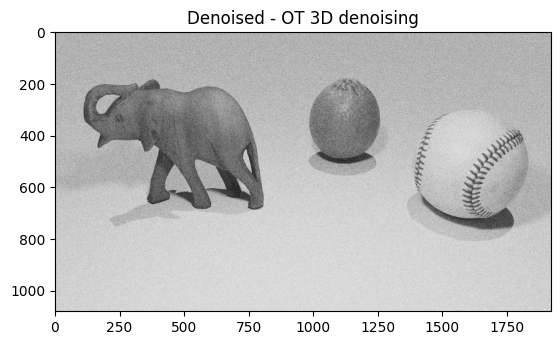

In [61]:
nm = 0
imshow(X_ot[nm], 'Denoised - OT 3D denoising')
print('PSNR OT 3D denoised Image:', psnr(img,normalize_2D(X_ot[nm])))
X_ot_avg = denoise_avg(X_ot)
print('PSNR OT 3D denoised Stack Average:', psnr(img,normalize_2D(X_ot_avg)))
# note: since we have to set upper threshold to 1, this transform doesn't sufficiently capture the variance of noise when done across 3D


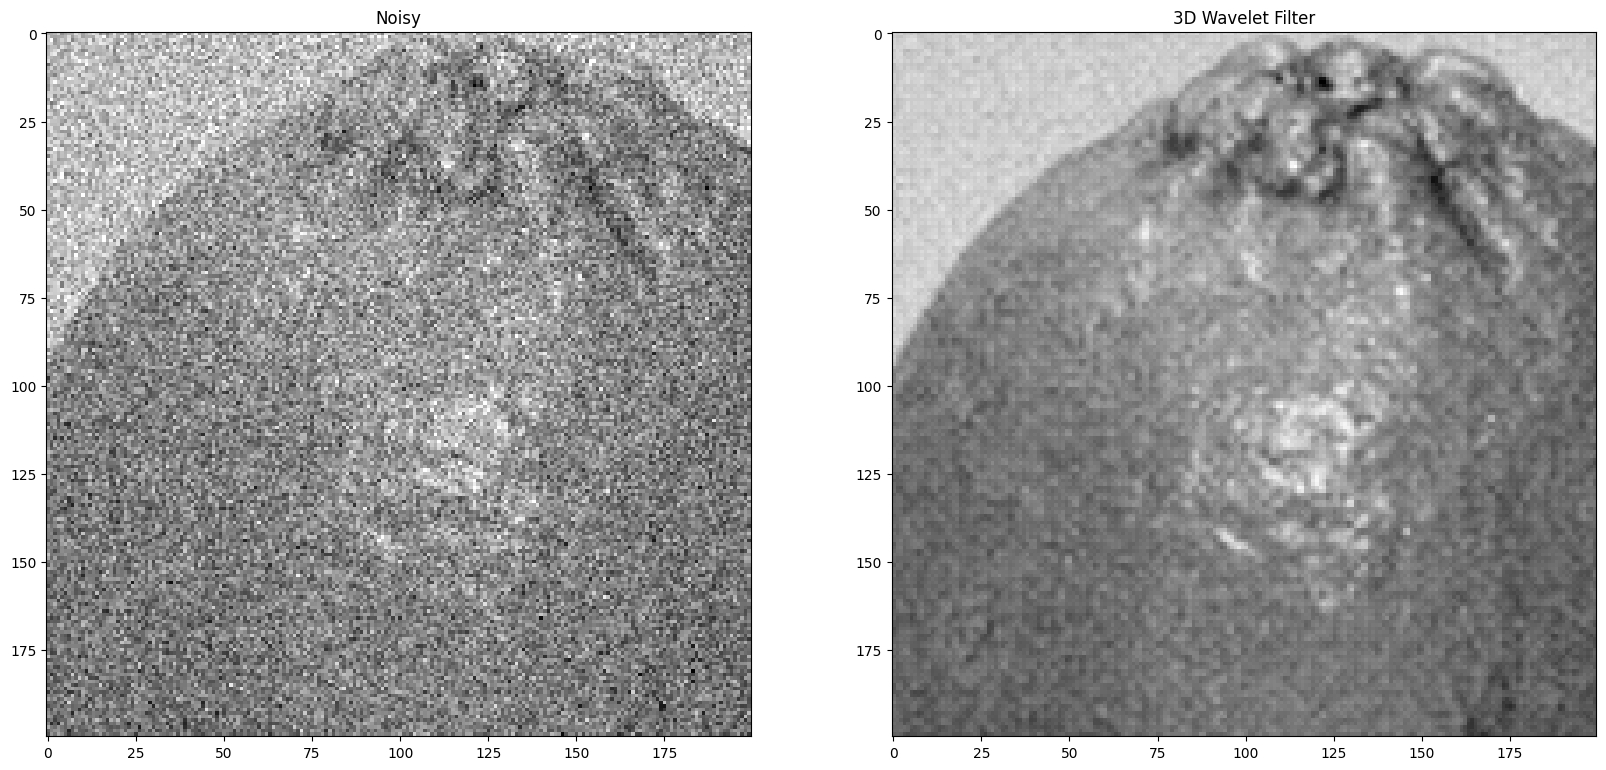

In [62]:
# Lime
h1 = 180; h2 = h1 + 200
w1 = 1000; w2 = w1 + 200
rect1 = [h1, h2, w1, w2]
imshowComparison(img_stack[C-1,:,:], X_ot_avg, rect1, "Noisy", "3D Wavelet Filter")

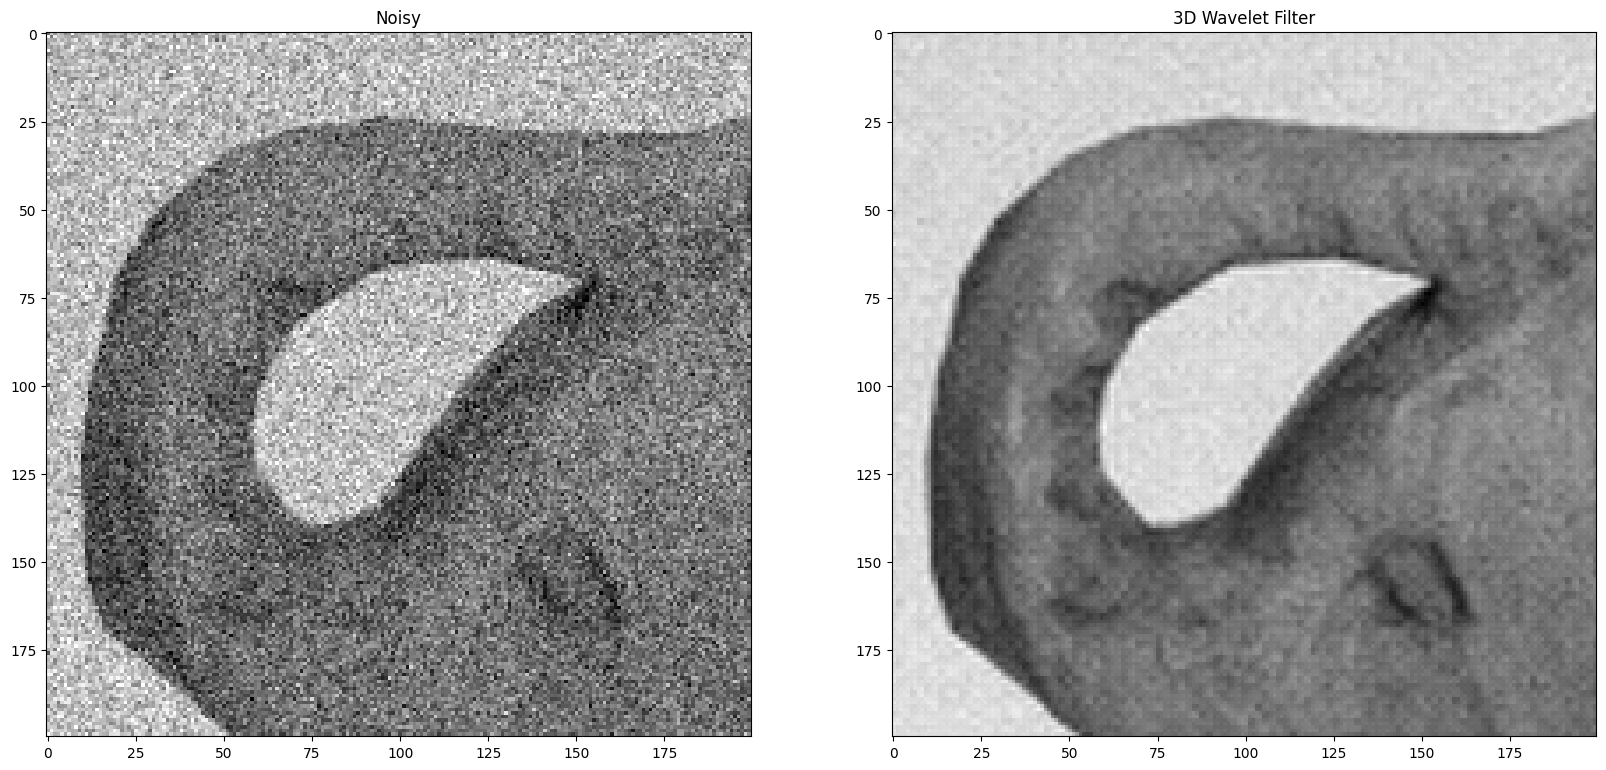

In [63]:
# Elephant
h1 = 180; h2 = h1 + 200
w1 = 100; w2 = w1 + 200
rect1 = [h1, h2, w1, w2]
imshowComparison(img_stack[C-1,:,:], X_ot_avg, rect1, "Noisy", "3D Wavelet Filter")

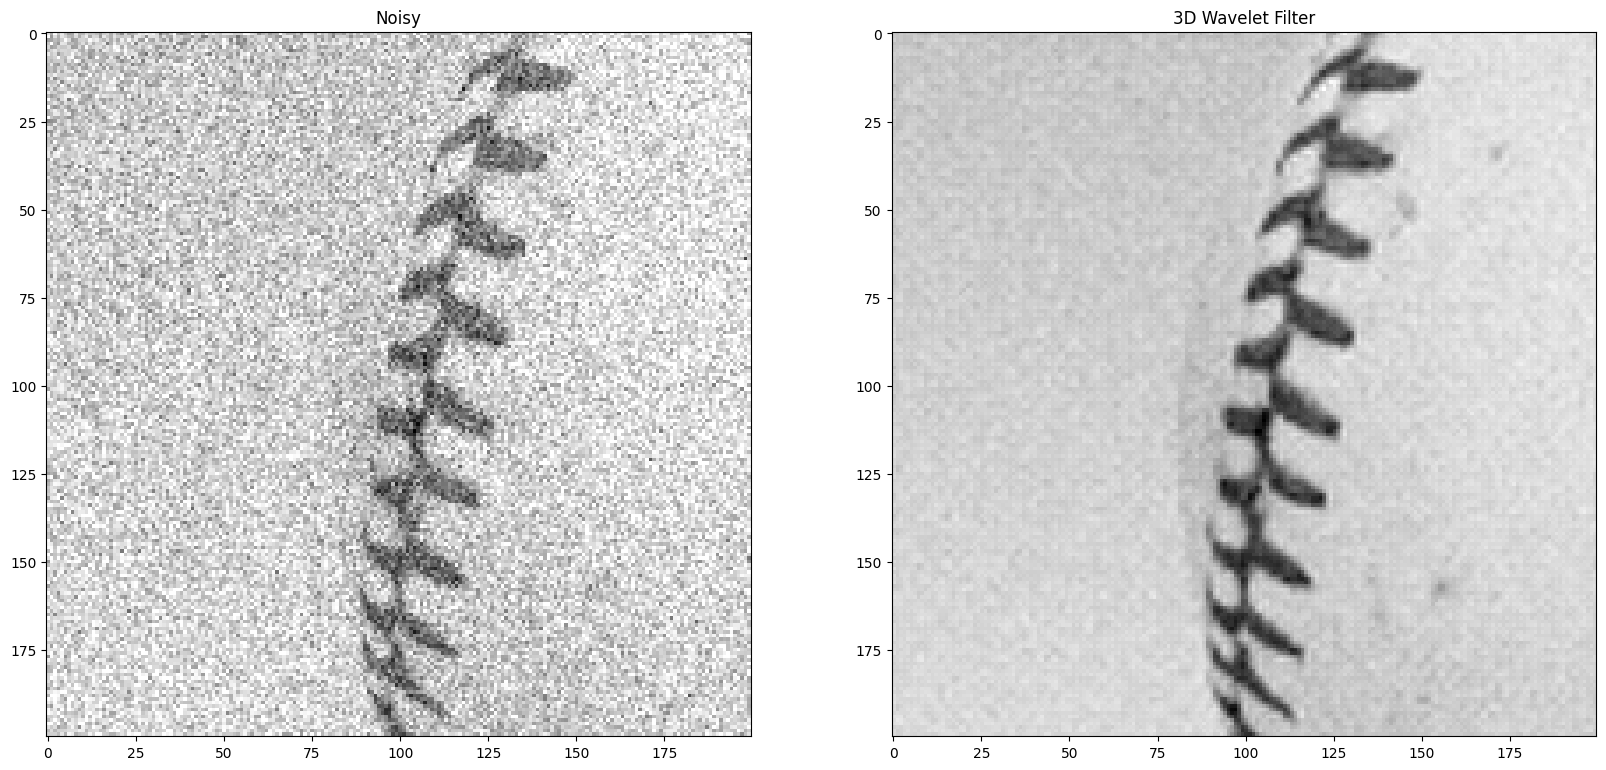

In [64]:
# Ball
h1 = 400; h2 = h1 + 200
w1 = 1300; w2 = w1 + 200
rect1 = [h1, h2, w1, w2]
imshowComparison(img_stack[C-1,:,:], X_ot_avg, rect1, "Noisy", "3D Wavelet Filter")

# Experimental Section

In this section the same three reconstruction algorithms are tested out on experimentally captured images.

Step 1 is to load in zip file "noisy_images_med_light.zip" into the working google colab directory. You can do this by dragging and dropping the folder into the Files tab

In [65]:
# Read in the ground truth image
gt = cv2.imread('experimental_data/gt_real.bmp')
gt = cv2.cvtColor(gt, cv2.COLOR_BGR2GRAY).astype(np.float64)
gt = normalize_2D(gt)

In [66]:
img_stack = np.load("experimental_data/img_noisy_stack_real.npy")

print(img_stack.shape)
[C, H, W] = img_stack.shape

(10, 2048, 2048)


Plot some example initial image results, full image and zoomed in region

PSNR Noisy Image: 25.447069499142035


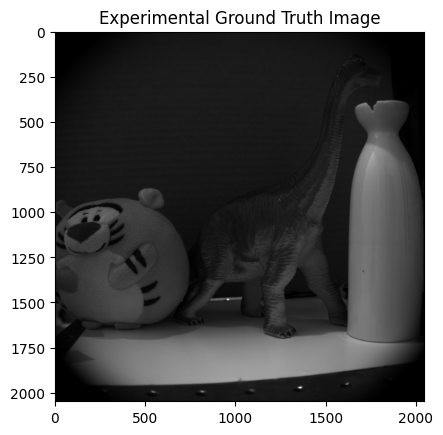

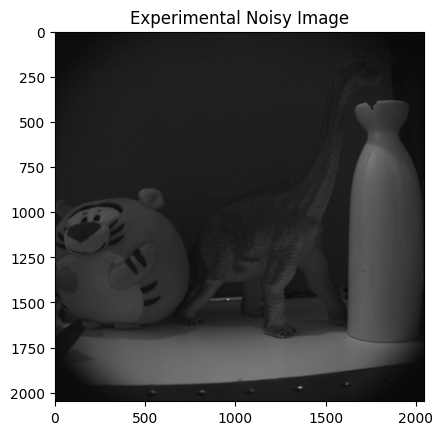

In [67]:
Z = img_stack
imshow(gt, "Experimental Ground Truth Image")
imshow(Z[0,:,:],"Experimental Noisy Image")
print('PSNR Noisy Image:', psnr(gt,normalize_2D(Z[1,:,:].squeeze())))

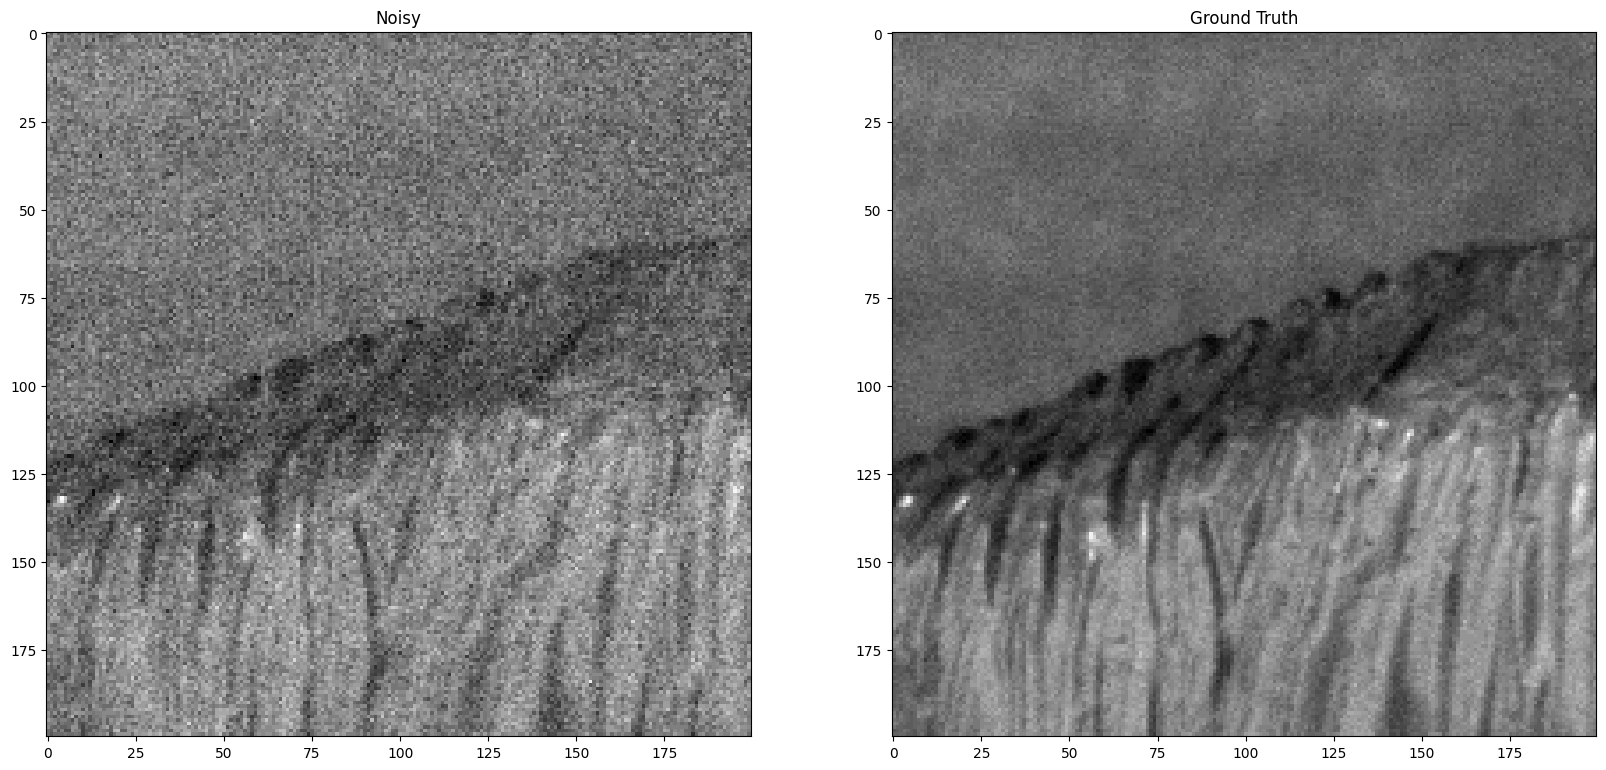

In [68]:
# Dinosaur back
h1 = 800; h2 = h1 + 200
w1 = 1000; w2 = w1 + 200
rect1 = [h1, h2, w1, w2]
imshowComparison(Z[1,:,:], gt, rect1, "Noisy", "Ground Truth")

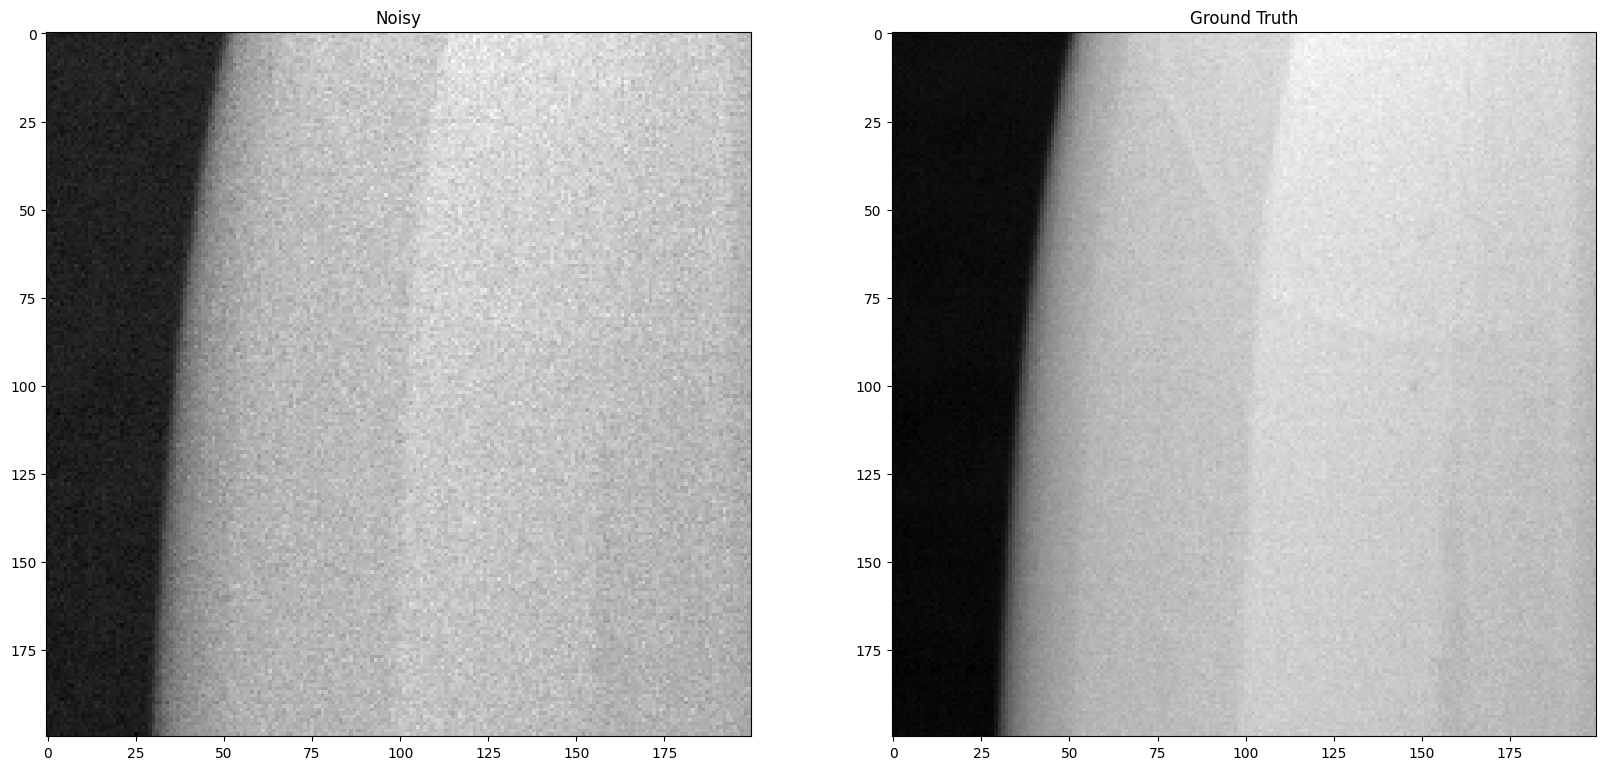

In [69]:
# Side of the specular vase
h1 = 800; h2 = h1 + 200
w1 = 1600; w2 = w1 + 200
rect2 = [h1, h2, w1, w2]
imshowComparison(Z[1,:,:], gt, rect2, "Noisy", "Ground Truth")

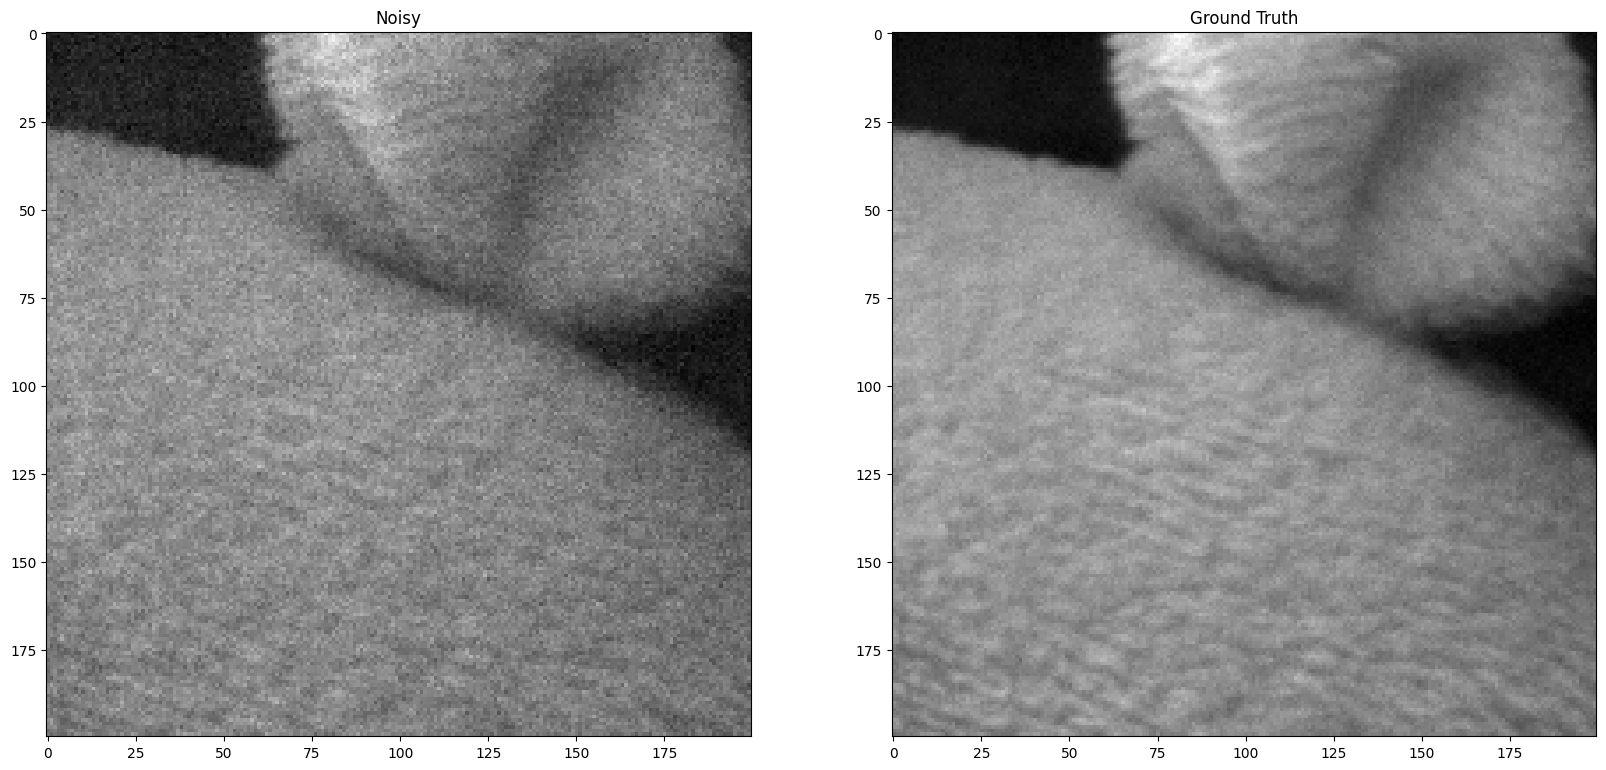

In [70]:
# Stuff animal face
h1 = 900; h2 = h1 + 200
w1 = 400; w2 = w1 + 200
rect3 = [h1, h2, w1, w2]
imshowComparison(Z[1,:,:], gt, rect3, "Noisy", "Ground Truth")


# Experimental denoising
In this section the different denoising methods are used on the experimental data.

PSNR Avg Image: 27.075951483357173
PSNR Avg Image: 26.209742394134203
(67502656,) 2073600
initial sigma estimate: 218.9088083086061
PSNR Avg Image: 26.03657489524476


'\nTODO:\nThe above code uses one of the filters developed above.\nApply each of the filters we developed on the experimental noisy stack,\nand show for each:\n(1) the output image,\n(2) along with its PSNR.\n\nWe also encourage you to play around with the relevant\nparameters of the functions (example, block size for the linear filter) for this dataset.\n'

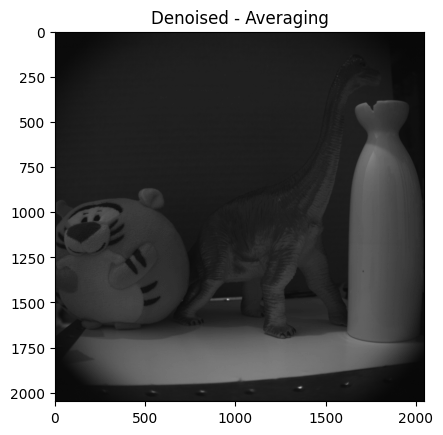

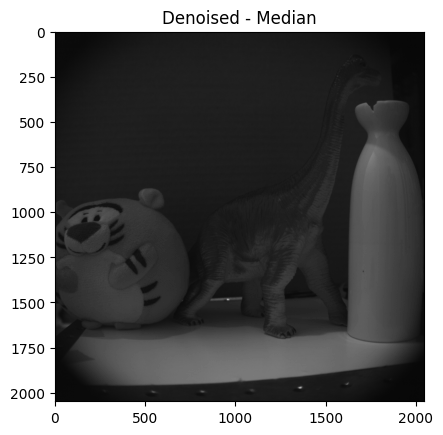

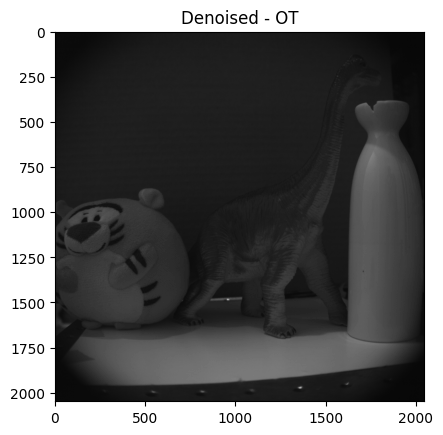

In [71]:
# W_avg = denoise_avg(Z)
W_avg = linear_filt_avg(Z, [6, 3, 3])
imshow(W_avg, "Denoised - Averaging")
print('PSNR Avg Image:', psnr(gt,normalize_2D(W_avg.squeeze())))

W_median = nonlinear_filt_median(Z, [6, 1, 1])
imshow(W_median, "Denoised - Median")
print('PSNR Avg Image:', psnr(gt,normalize_2D(W_median.squeeze())))

W_ot_denoise = ot_denoising3D(Z, transform=wavelet3D, inv_transform=iwavelet3D)
imshow(W_median, "Denoised - OT")
print('PSNR Avg Image:', psnr(gt,normalize_2D(denoise_avg(W_ot_denoise).squeeze())))

'''
TODO:
The above code uses one of the filters developed above.
Apply each of the filters we developed on the experimental noisy stack,
and show for each:
(1) the output image,
(2) along with its PSNR.

We also encourage you to play around with the relevant
parameters of the functions (example, block size for the linear filter) for this dataset.
'''

(67502656,) 2073600
initial sigma estimate: 10.36034300980013
PSNR Avg Image: 13.655086045999429


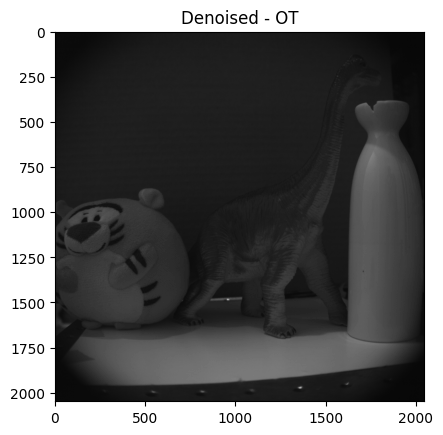

In [81]:
# W_ot_denoise = ot_denoising3D(Z, transform=wavelet3D, inv_transform=iwavelet3D, percent_hi=.25, percent_lo=0.00025)
# imshow(W_median, "Denoised - OT")
# print('PSNR Avg Image:', psnr(gt,normalize_2D(denoise_avg(W_ot_denoise).squeeze())))

Text(0.5, 1.0, 'Ground Truth')

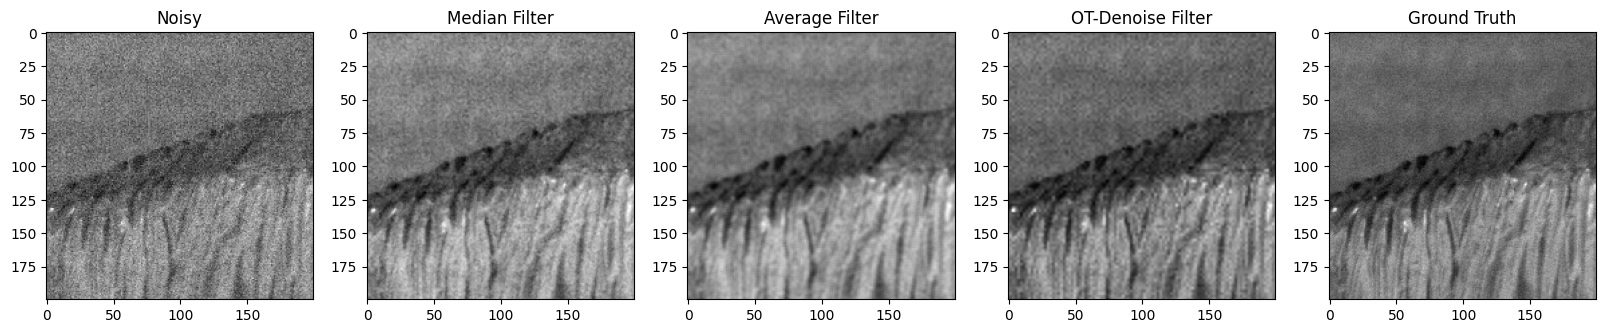

In [72]:
'''
TODO:
In this fashion below, plot all the denoised images
in one or more row(s) for comparison. Refer to HW description
for more details.
'''

# Dinosaur back
h1 = 800; h2 = h1 + 200
w1 = 1000; w2 = w1 + 200

# plot the results in a single plot
cmap_color = 'gray'
fig, axs = plt.subplots(1, 5, figsize=(20,100))
# fig.suptitle('Denoising Methods')
axs[0].imshow(normalize_2D(Z[1,:,:].squeeze())[h1:h2,w1:w2], cmap=cmap_color)
axs[0].set_title('Noisy')
axs[1].imshow(normalize_2D(W_median.squeeze())[h1:h2,w1:w2], cmap=cmap_color)
axs[1].set_title('Median Filter')
axs[2].imshow(normalize_2D(W_avg.squeeze())[h1:h2,w1:w2], cmap=cmap_color)
axs[2].set_title('Average Filter')
axs[3].imshow(normalize_2D(denoise_avg(W_ot_denoise))[h1:h2,w1:w2], cmap=cmap_color)
axs[3].set_title('OT-Denoise Filter')
axs[4].imshow(gt[h1:h2,w1:w2], cmap=cmap_color)
axs[4].set_title('Ground Truth')

Text(0.5, 1.0, 'Ground Truth')

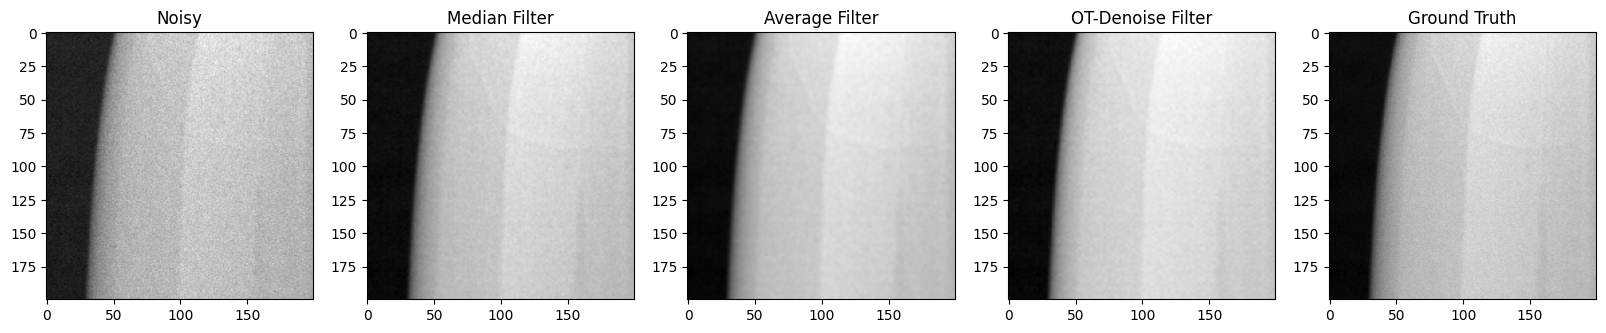

In [73]:
'''
TODO:
In this fashion below, plot all the denoised images
in one or more row(s) for comparison. Refer to HW description
for more details.
'''

# Side of the specular vase
h1 = 800; h2 = h1 + 200
w1 = 1600; w2 = w1 + 200

# plot the results in a single plot
cmap_color = 'gray'
fig, axs = plt.subplots(1, 5, figsize=(20,100))
# fig.suptitle('Denoising Methods')
axs[0].imshow(normalize_2D(Z[1,:,:].squeeze())[h1:h2,w1:w2], cmap=cmap_color)
axs[0].set_title('Noisy')
axs[1].imshow(normalize_2D(W_median.squeeze())[h1:h2,w1:w2], cmap=cmap_color)
axs[1].set_title('Median Filter')
axs[2].imshow(normalize_2D(W_avg.squeeze())[h1:h2,w1:w2], cmap=cmap_color)
axs[2].set_title('Average Filter')
axs[3].imshow(normalize_2D(denoise_avg(W_ot_denoise))[h1:h2,w1:w2], cmap=cmap_color)
axs[3].set_title('OT-Denoise Filter')
axs[4].imshow(gt[h1:h2,w1:w2], cmap=cmap_color)
axs[4].set_title('Ground Truth')

Text(0.5, 1.0, 'Ground Truth')

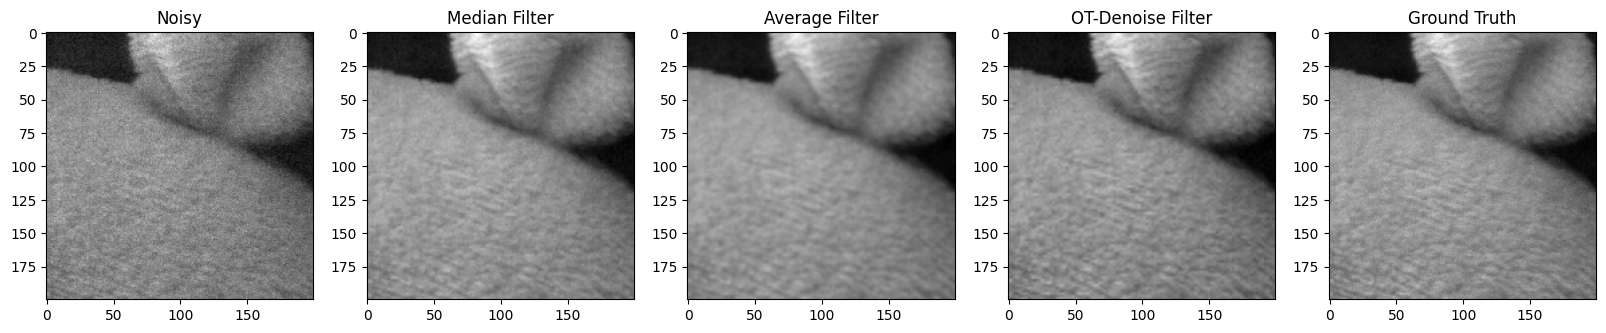

In [74]:
'''
TODO:
In this fashion below, plot all the denoised images
in one or more row(s) for comparison. Refer to HW description
for more details.
'''

# Stuff animal face
h1 = 900; h2 = h1 + 200
w1 = 400; w2 = w1 + 200

# plot the results in a single plot
cmap_color = 'gray'
fig, axs = plt.subplots(1, 5, figsize=(20,100))
# fig.suptitle('Denoising Methods')
axs[0].imshow(normalize_2D(Z[1,:,:].squeeze())[h1:h2,w1:w2], cmap=cmap_color)
axs[0].set_title('Noisy')
axs[1].imshow(normalize_2D(W_median.squeeze())[h1:h2,w1:w2], cmap=cmap_color)
axs[1].set_title('Median Filter')
axs[2].imshow(normalize_2D(W_avg.squeeze())[h1:h2,w1:w2], cmap=cmap_color)
axs[2].set_title('Average Filter')
axs[3].imshow(normalize_2D(denoise_avg(W_ot_denoise))[h1:h2,w1:w2], cmap=cmap_color)
axs[3].set_title('OT-Denoise Filter')
axs[4].imshow(gt[h1:h2,w1:w2], cmap=cmap_color)
axs[4].set_title('Ground Truth')

In [75]:
# note: add psnr to the cropped images and we're good... turn in after joe's, then look at joe's hw after dinner before oh